In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras
from sklearn.metrics import matthews_corrcoef, accuracy_score, root_mean_squared_error, mean_squared_error, mean_absolute_error, precision_score, confusion_matrix, multilabel_confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm
import time
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import gc
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

2025-04-08 19:32:47.385947: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744129967.402606  117285 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744129967.407569  117285 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744129967.420112  117285 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744129967.420130  117285 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744129967.420131  117285 computation_placer.cc:177] computation placer alr

# Functions

In [2]:
def visualize_CM(matrix):
    """
    Visualize Correlation Matrix
    """
    sns.heatmap(matrix,annot=True)

def result_plot(_dict, name, folder, model_name):
    """
    Plot results for multiclass classification
    """
    attacks = {}
    higher = ["F1", "Accuracy", "Precision", "Recall", "MCC", "precision", "recall", "f1-score", "support", 'Benign', 'Bruteforce', 'DDoS', 'DoS', 'Mirai', 'Recon', 'Spoofing',
       'Web']
    fig, ax = plt.subplots(figsize=(10,10))
    if name in higher:
        tmp = sorted(_dict.items(), key = lambda x:x[1])
    else:
        tmp = sorted(_dict.items(), key = lambda x:x[1], reverse=True)
    for x in tmp:
        attacks[x[0]] = x[1]
    ax.bar(attacks.keys(), attacks.values())
    rects = ax.patches
    results = [i for i in attacks.values()]
    labels = [f"{results[i]:.6f}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom"
        )
    if name in higher:
        name = name.capitalize()
        ax.set_title(f'{name} (higher is better)', fontsize=16, fontweight="bold")
    else:
        ax.set_title(f'{name} (lower is better)', fontsize=16, fontweight="bold")
    ax.set_xlabel(f'{name}')
    ax.set_ylabel('Score')
    ax.grid(which='Major', axis='both')
    ax.set_axisbelow(True)
    if (model_name == ""):
        plt.savefig(f"images/results/{folder}/30000/{name}.png")
    else:
        plt.savefig(f"images/results/{folder}/30000/{name}_{model_name}.png")

def plot_mc(y_pred, y_test, model_name, mc_results = {}):
    """
    Plots Precision, Recall and F1 scores for each class in multiclass classification
    """
    cr = classification_report(y_pred, y_test, output_dict=True)
    for key, name in cr.items():
        if key not in ['accuracy', 'macro avg', 'weighted avg'] and int(key) in attack_dict:
            mc_results[attack_dict[int(key)]] = cr[key]
    mc_results = pd.DataFrame(mc_results).drop(['support'], axis = 0)
    for key in mc_results.keys():
        result_plot(mc_results[key], key, "multiclass_by_class", model_name)

# Load data

In [3]:
data = pd.read_csv('data/CIC_IoT2023/custom/multiclass_classification_data_30000.csv')

In [4]:
data = data.drop(['Unnamed: 0', 'label', 'Class'], axis=1)

In [5]:
data.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Attack Type
0,0.0,0.0,0.99,65.27,1.232415,1.232415,0.0,0.0,0.0,0.0,...,0.617394,42.18,8.312856e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55,DDoS
1,0.0,54.0,6.00,64.00,31.840037,31.840037,0.0,0.0,1.0,0.0,...,0.000000,54.00,8.309343e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS
2,0.0,0.0,0.99,63.36,2.481472,2.481472,0.0,0.0,0.0,0.0,...,0.617394,42.18,8.314964e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55,DDoS
3,0.0,54.0,6.00,64.00,4.499163,4.499163,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.333215e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS
4,0.0,54.0,6.00,64.00,15.849033,15.849033,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.307156e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS


In [6]:
data.tail()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Attack Type
217888,3066.037345,10267.5,11.5,130.5,1.029689,1.029689,0.0,0.0,0.0,0.0,...,48.073719,175.9,4.020541e-02,5.5,15.420603,67.986505,3619.117272,0.9,38.5,Bruteforce
217889,343.000496,106722.4,12.6,96.3,3.483237,3.483237,0.0,0.0,0.0,0.0,...,53.837593,81.8,1.666014e+08,13.5,13.133269,76.311509,2921.188688,1.0,244.6,Bruteforce
217890,199.262425,16583.6,9.3,118.9,0.319272,0.319272,0.0,0.0,0.0,0.0,...,71.998962,101.7,2.843370e-02,5.5,14.011221,101.821908,7002.672673,0.9,38.5,Bruteforce
217891,177.979327,29709.7,9.3,93.8,1.760932,1.760932,0.0,0.0,0.0,0.0,...,66.139131,94.8,1.666014e+08,13.5,14.883212,93.714094,4411.596919,1.0,244.6,Bruteforce
217892,299.487685,38503.2,15.3,57.6,2.423920,2.423920,0.0,0.0,0.0,0.0,...,77.932213,137.4,1.224859e-02,5.5,14.286196,110.212793,9866.644535,0.9,38.5,Bruteforce


In [7]:
X = data.drop(['Attack Type'], axis = 1)
y = data['Attack Type']

In [8]:
X.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,AVG,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight
0,0.0,0.0,0.99,65.27,1.232415,1.232415,0.0,0.0,0.0,0.0,...,42.180879,0.617394,42.18,8.312856e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55
1,0.0,54.0,6.00,64.00,31.840037,31.840037,0.0,0.0,1.0,0.0,...,54.000000,0.000000,54.00,8.309343e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55
2,0.0,0.0,0.99,63.36,2.481472,2.481472,0.0,0.0,0.0,0.0,...,42.180879,0.617394,42.18,8.314964e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55
3,0.0,54.0,6.00,64.00,4.499163,4.499163,0.0,0.0,0.0,0.0,...,54.000000,0.000000,54.00,8.333215e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55
4,0.0,54.0,6.00,64.00,15.849033,15.849033,0.0,0.0,0.0,0.0,...,54.000000,0.000000,54.00,8.307156e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55


In [9]:
y

0               DDoS
1               DDoS
2               DDoS
3               DDoS
4               DDoS
             ...    
217888    Bruteforce
217889    Bruteforce
217890    Bruteforce
217891    Bruteforce
217892    Bruteforce
Name: Attack Type, Length: 217893, dtype: object

In [10]:
le = LabelEncoder()

data['Attack Number'] = le.fit_transform(y)
y = data['Attack Number']

In [11]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [12]:
attack_dict = {}
encoded_values = data['Attack Number'].unique()
for val in sorted(encoded_values):
    attack_dict[val] = le.inverse_transform([val])[0]
    print(f"{val}: {le.inverse_transform([val])[0]}")

0: Benign
1: Bruteforce
2: DDoS
3: DoS
4: Mirai
5: Recon
6: Spoofing
7: Web


# Multiclass Classification

In [13]:
results_dict = {}

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((185209, 46), (185209,), (32684, 46), (32684,))

# K Nearest Neighbour

In [15]:
%%time

start = time.time()

knn_clf = KNeighborsClassifier(n_jobs=8)
knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)

end = time.time()

KNN_time = end - start

CPU times: user 36.6 s, sys: 28.4 ms, total: 36.6 s
Wall time: 9.34 s


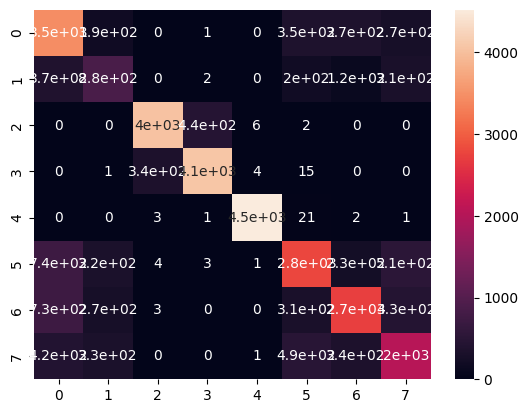

In [16]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [17]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [18]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, KNN_time]
results_dict["kNN"] = results

In [19]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.749908,0.753848,0.749968,0.749908,0.712982,0.906284,4.565078,2.136604,9.339322


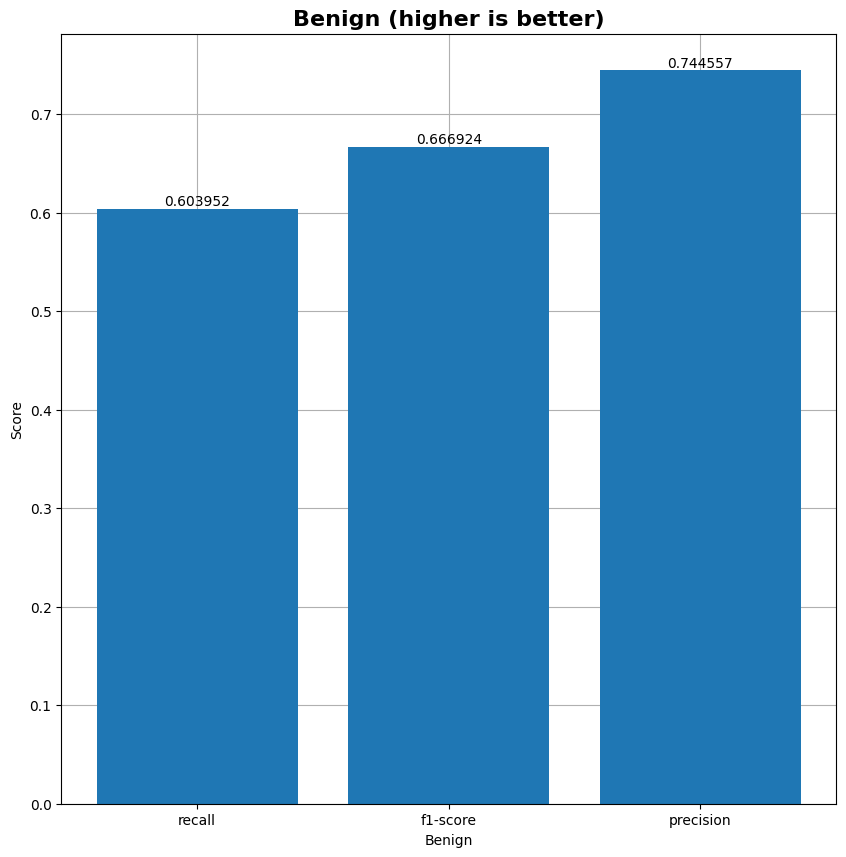

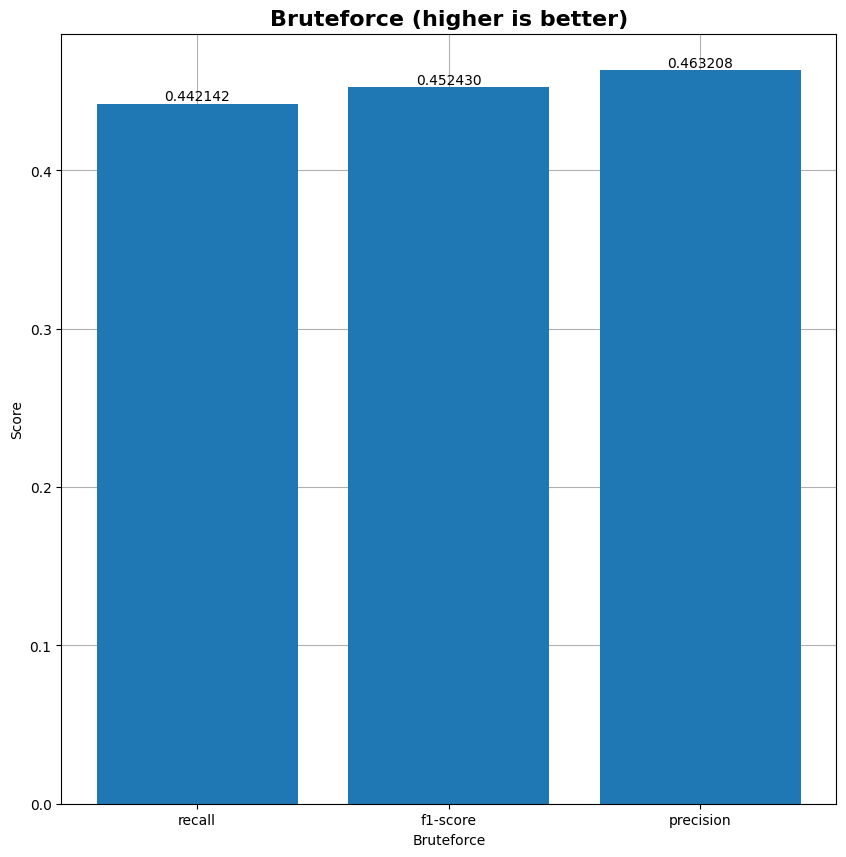

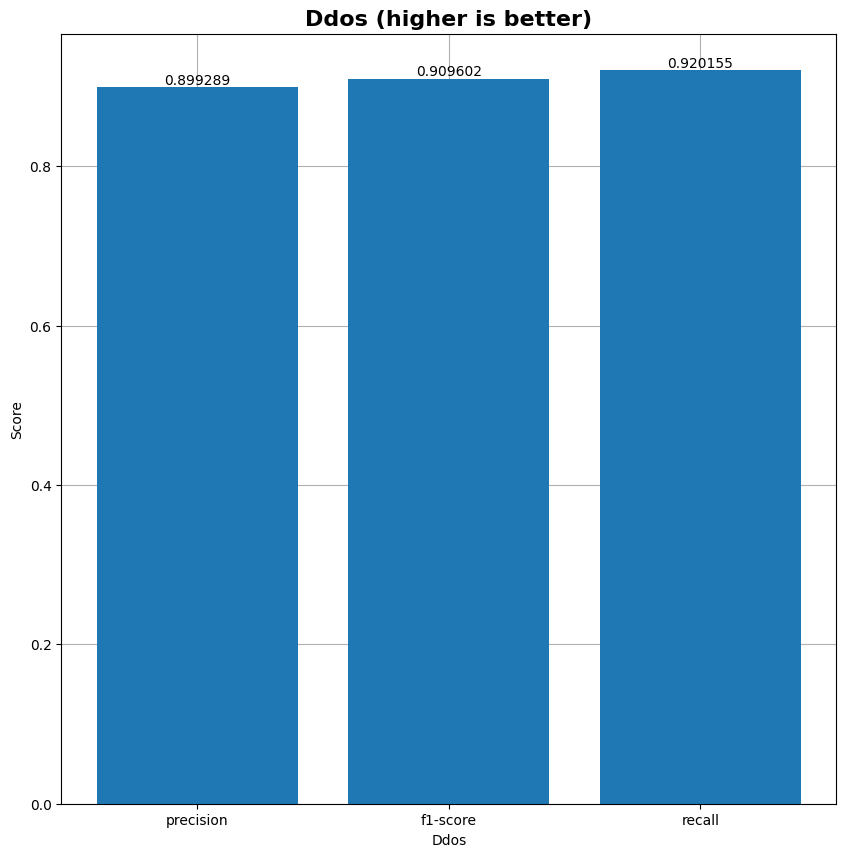

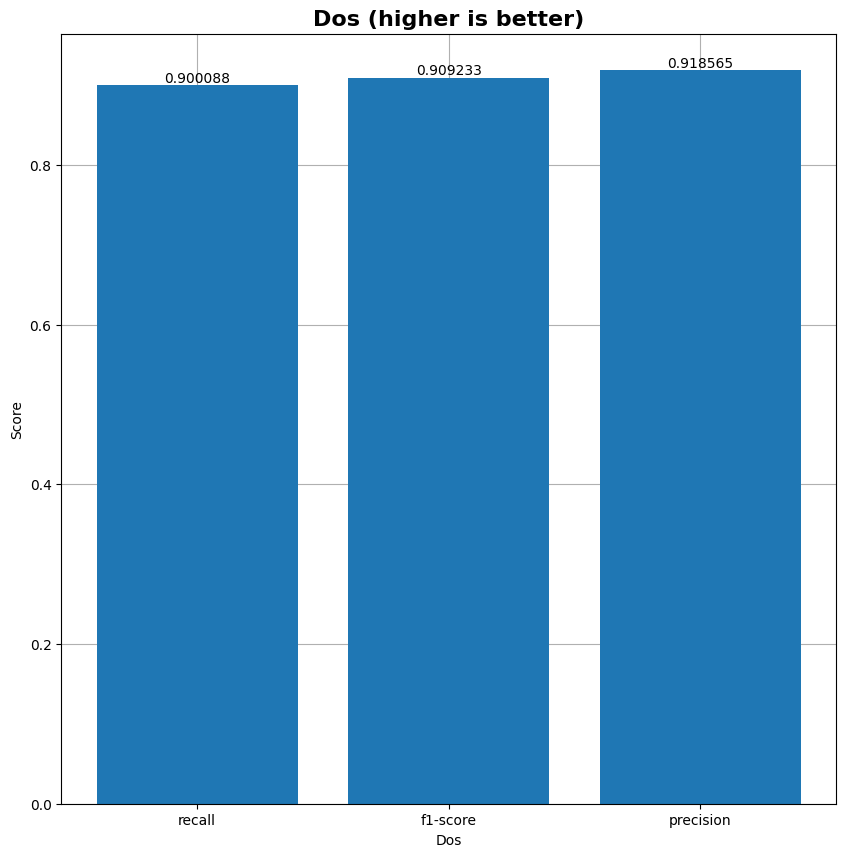

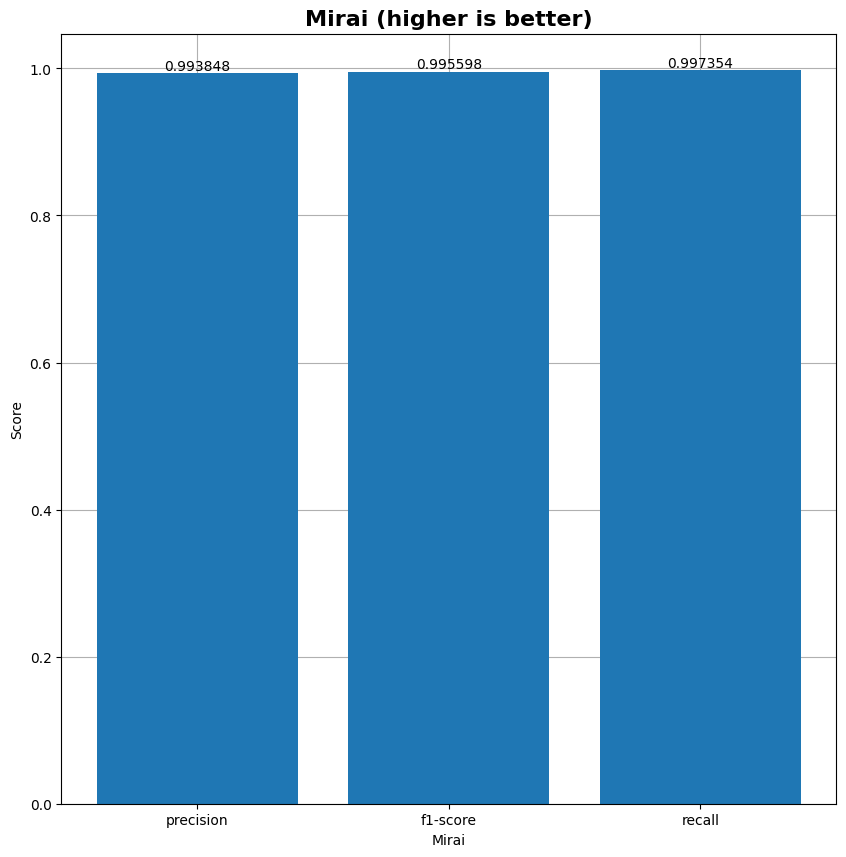

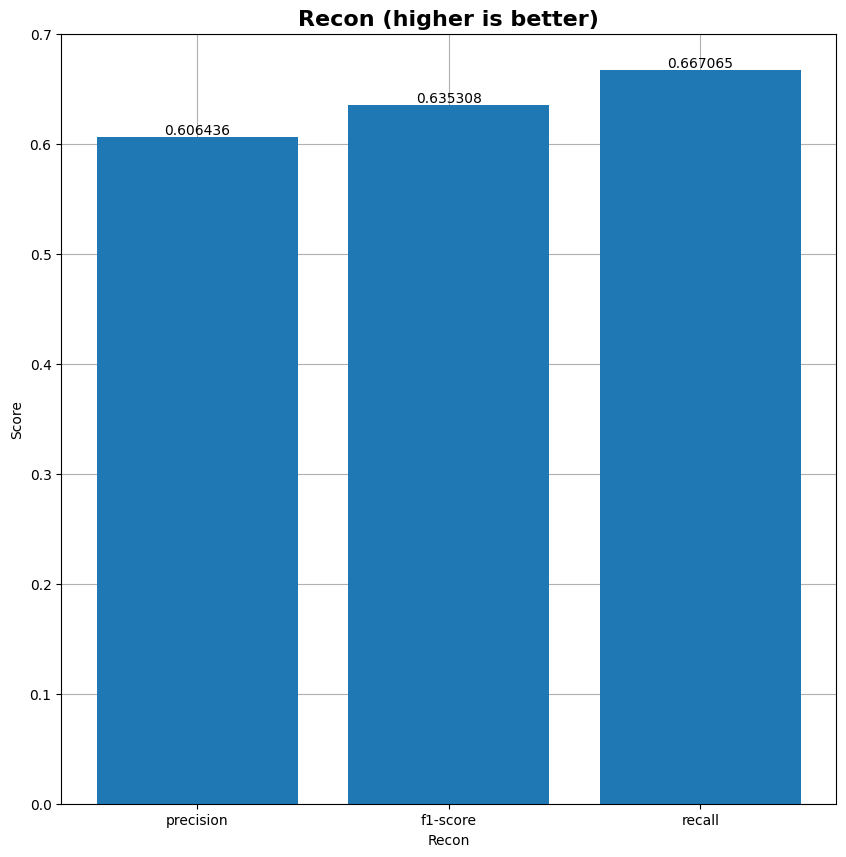

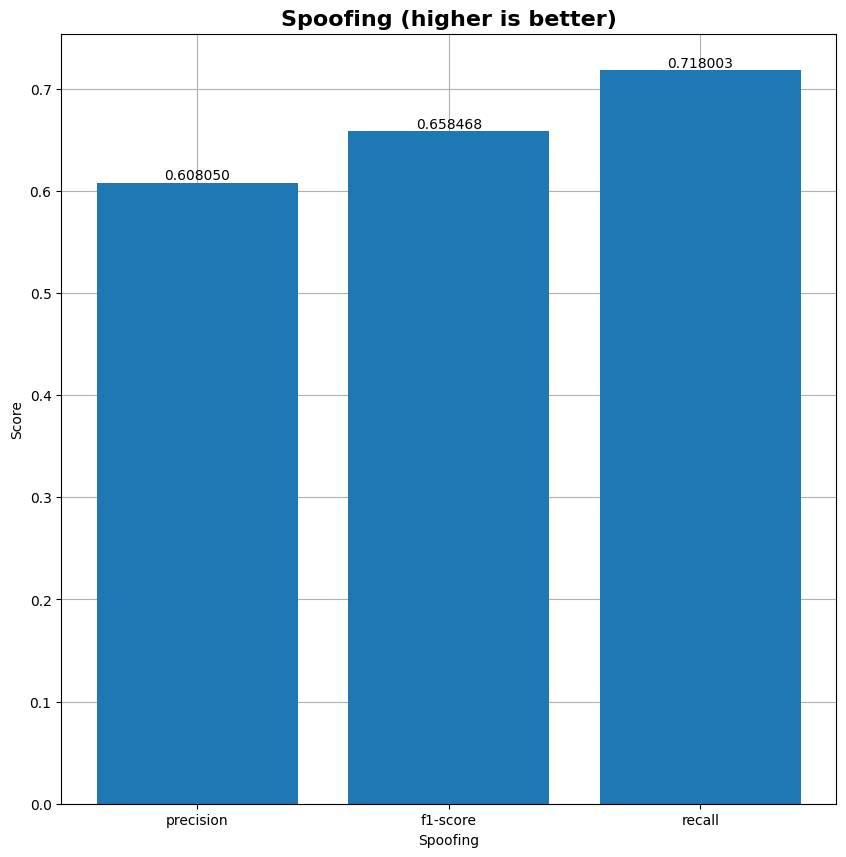

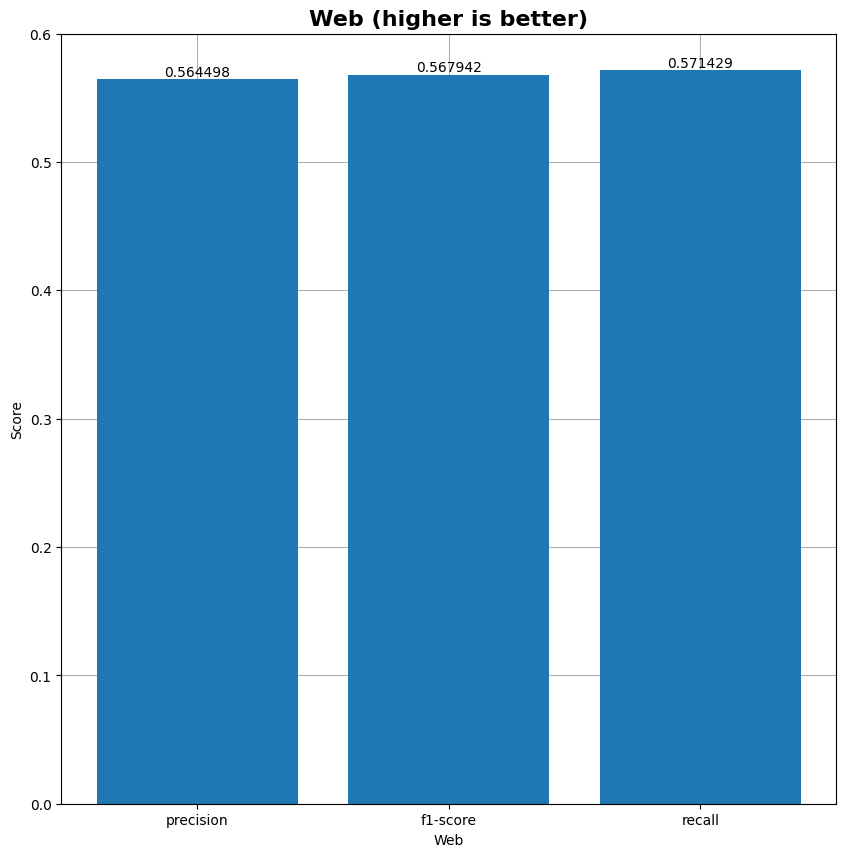

In [20]:
plot_mc(y_pred, y_test, "kNN")

# Logistic Regression

In [21]:
%%time

start = time.time()

lr_clf = LogisticRegression(max_iter = 10000, C = 0.1, random_state = 0, solver = 'saga', n_jobs=8)
lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_test)

end = time.time()

LR_time = end - start

CPU times: user 17min 32s, sys: 951 ms, total: 17min 33s
Wall time: 17min 36s


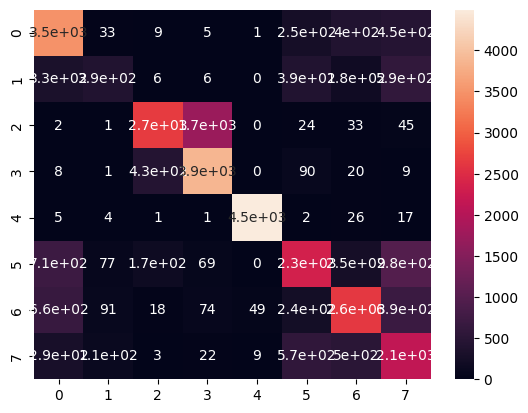

In [22]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [23]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [24]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, LR_time]
results_dict["LR"] = results

In [25]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.749908,0.753848,0.749968,0.749908,0.712982,0.906284,4.565078,2.136604,9.339322
LR,0.673479,0.682574,0.666665,0.673479,0.626146,1.012544,4.725921,2.173918,1056.777531


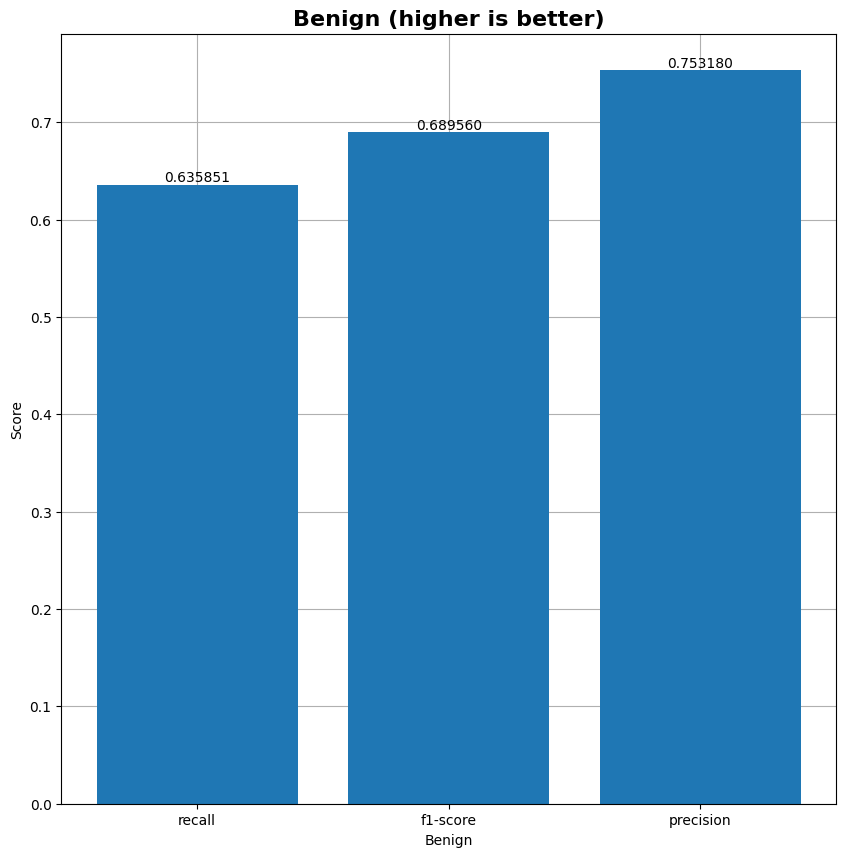

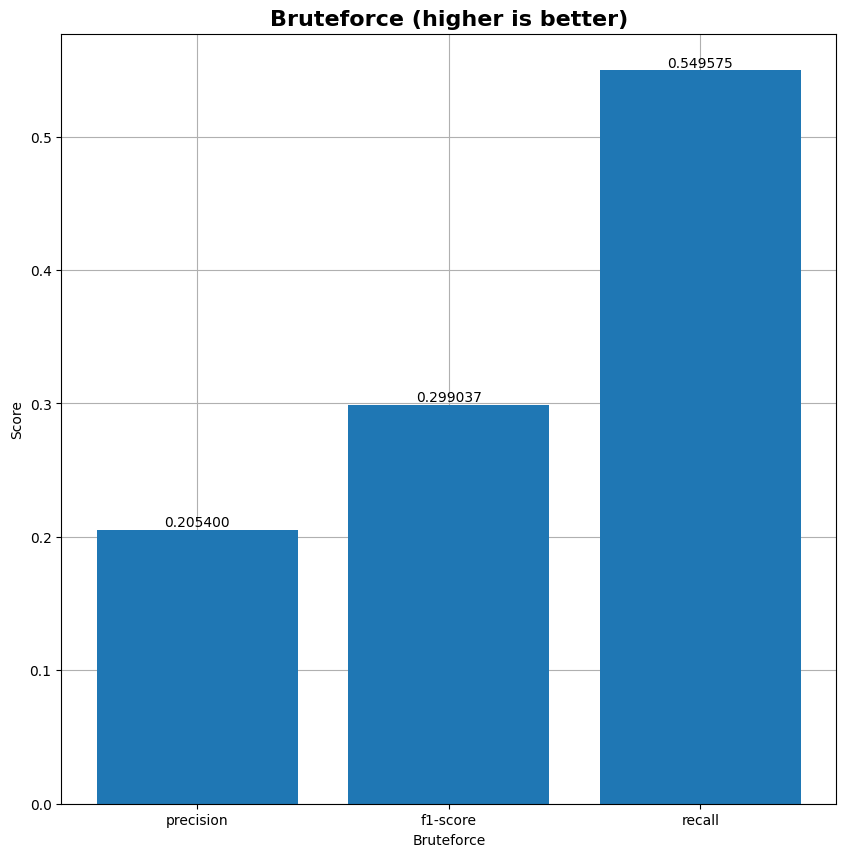

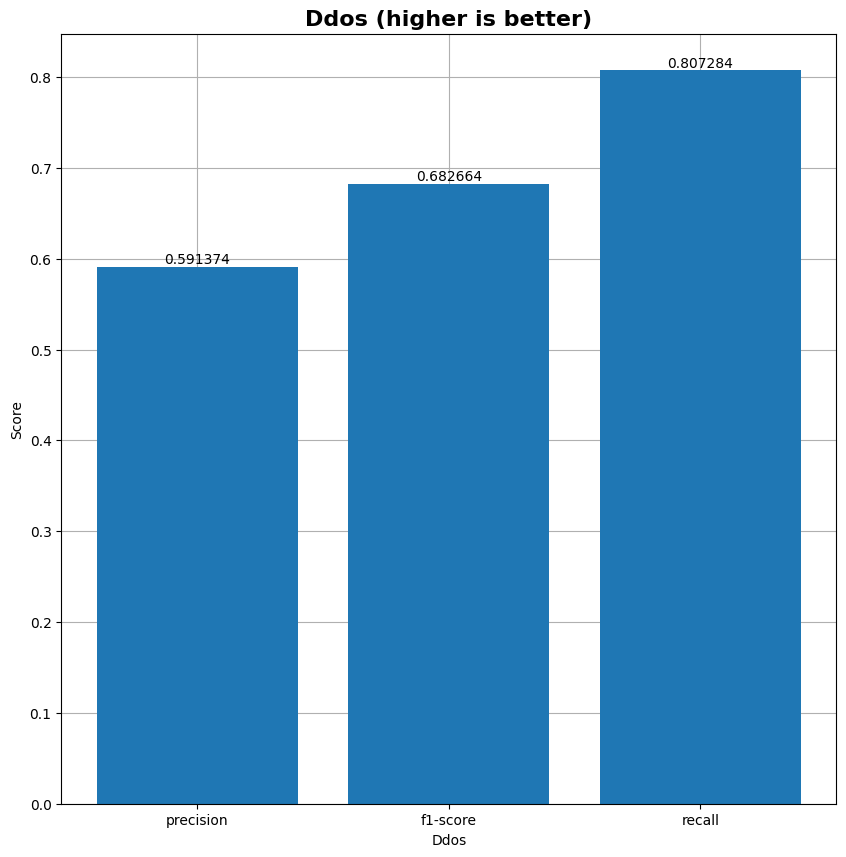

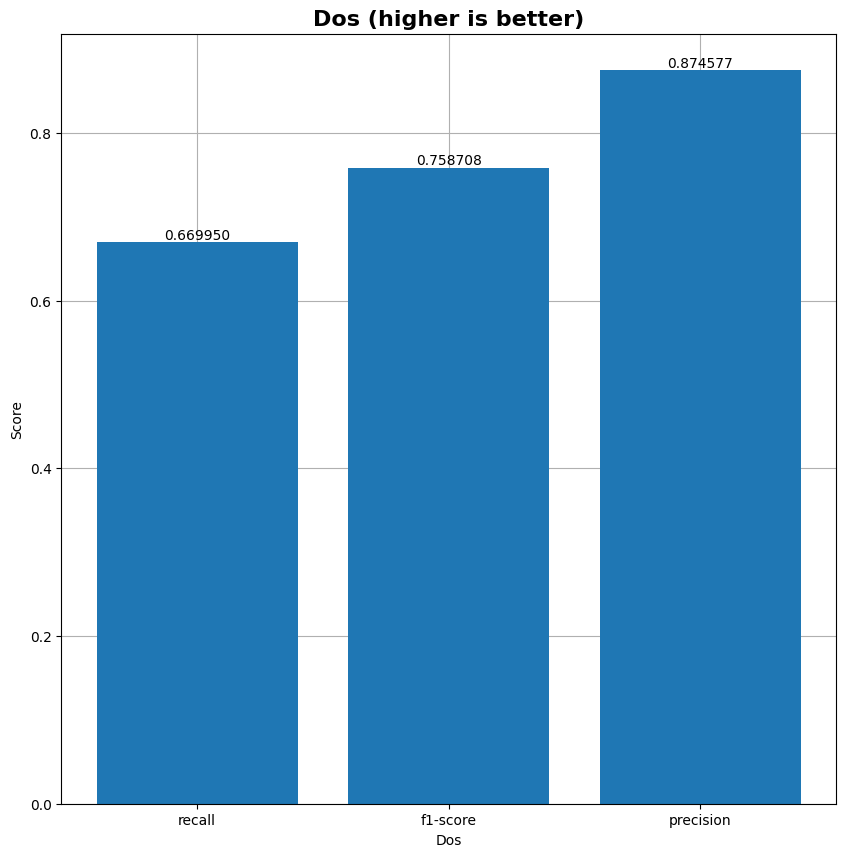

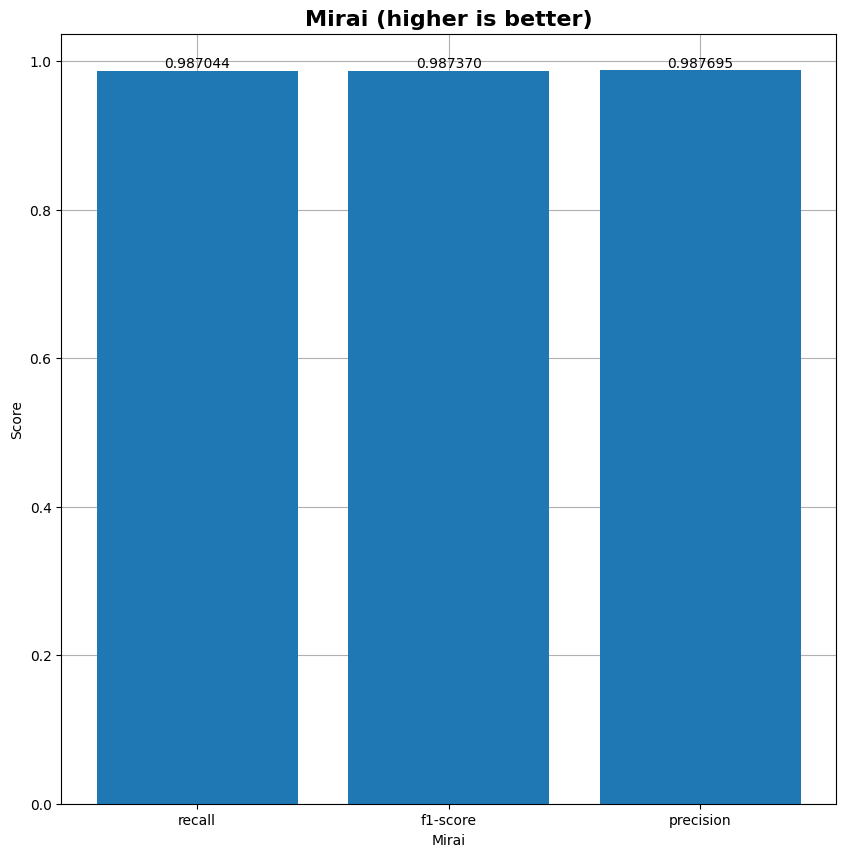

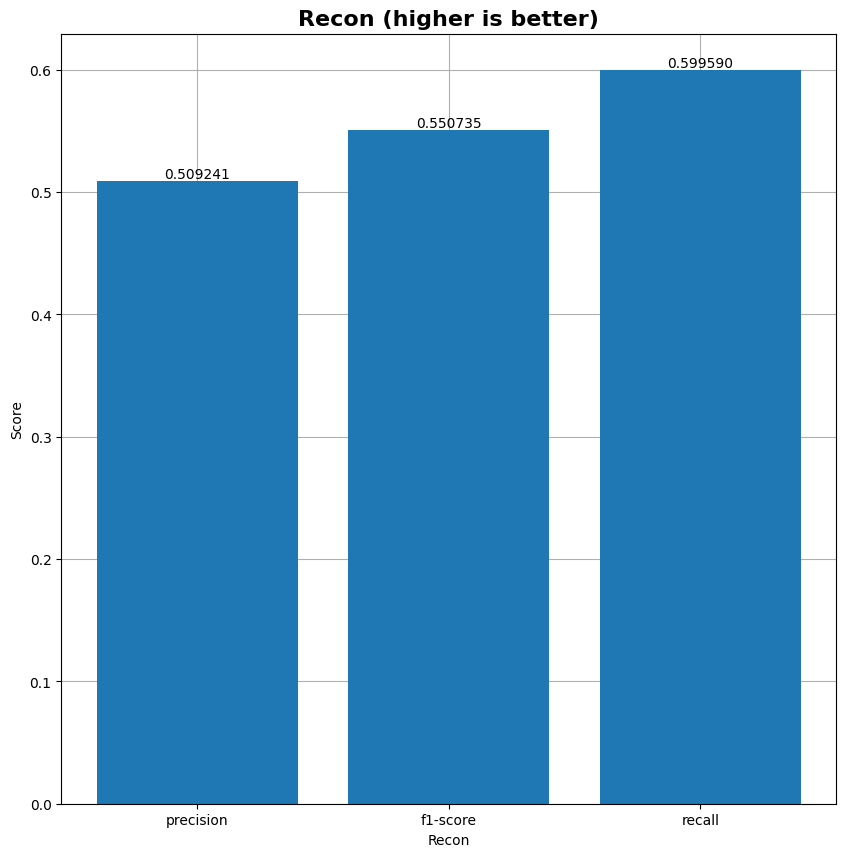

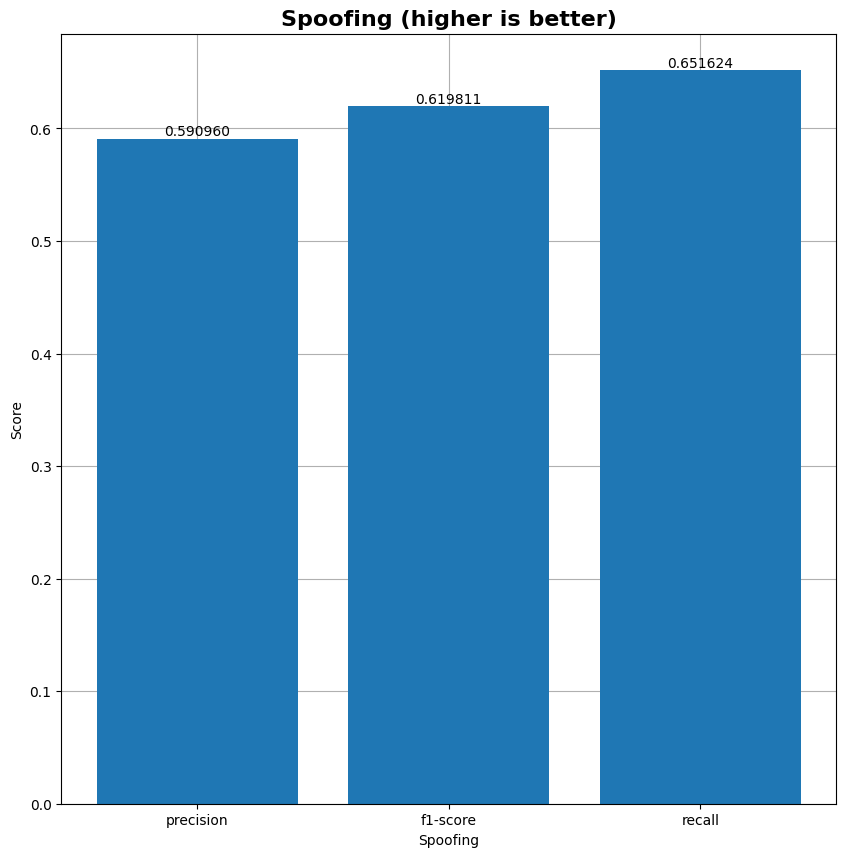

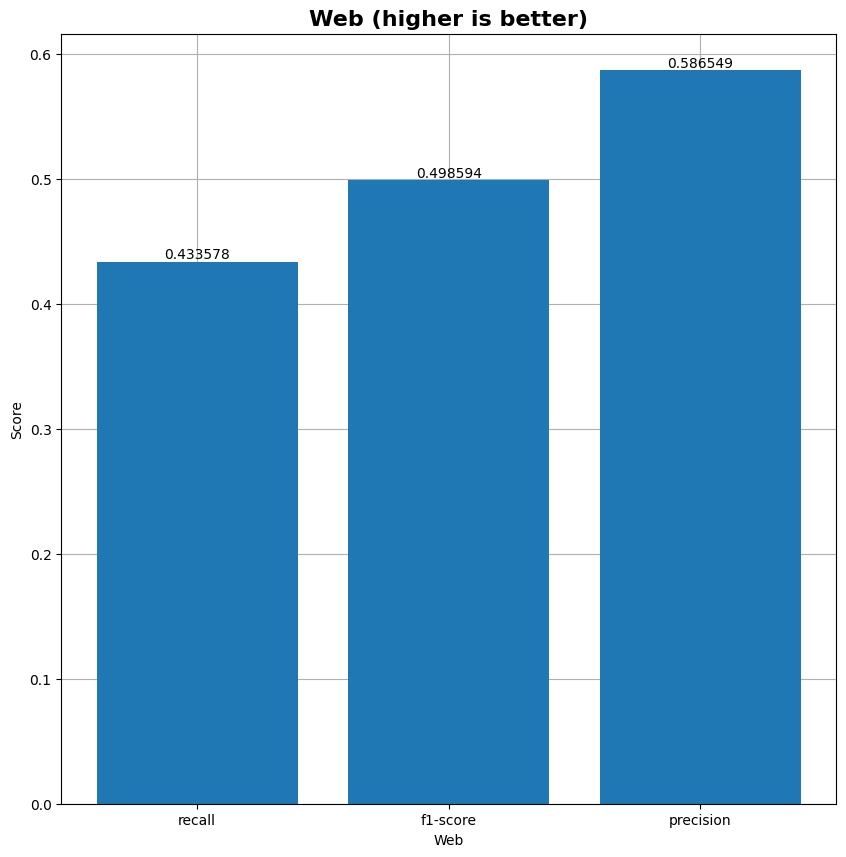

In [26]:
plot_mc(y_pred, y_test, "LR")

# Random Forest

In [27]:
%%time

start = time.time()

rf_clf = RandomForestClassifier(n_jobs=8)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

end = time.time()

RF_time = end - start

CPU times: user 1min 27s, sys: 386 ms, total: 1min 28s
Wall time: 11.8 s


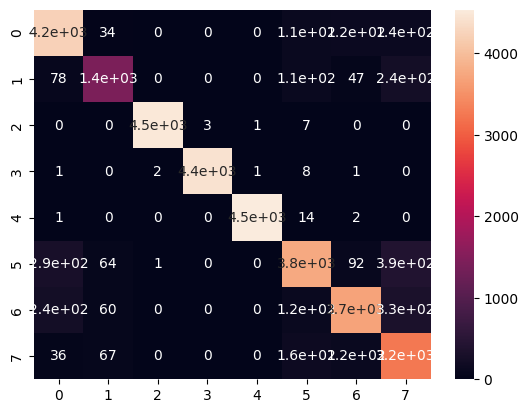

In [28]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [29]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [30]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, RF_time]
results_dict["RF"] = results

In [31]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.749908,0.753848,0.749968,0.749908,0.712982,0.906284,4.565078,2.136604,9.339322
LR,0.673479,0.682574,0.666665,0.673479,0.626146,1.012544,4.725921,2.173918,1056.777531
RF,0.911608,0.914864,0.911837,0.911608,0.898712,0.318872,1.569942,1.252973,11.841325


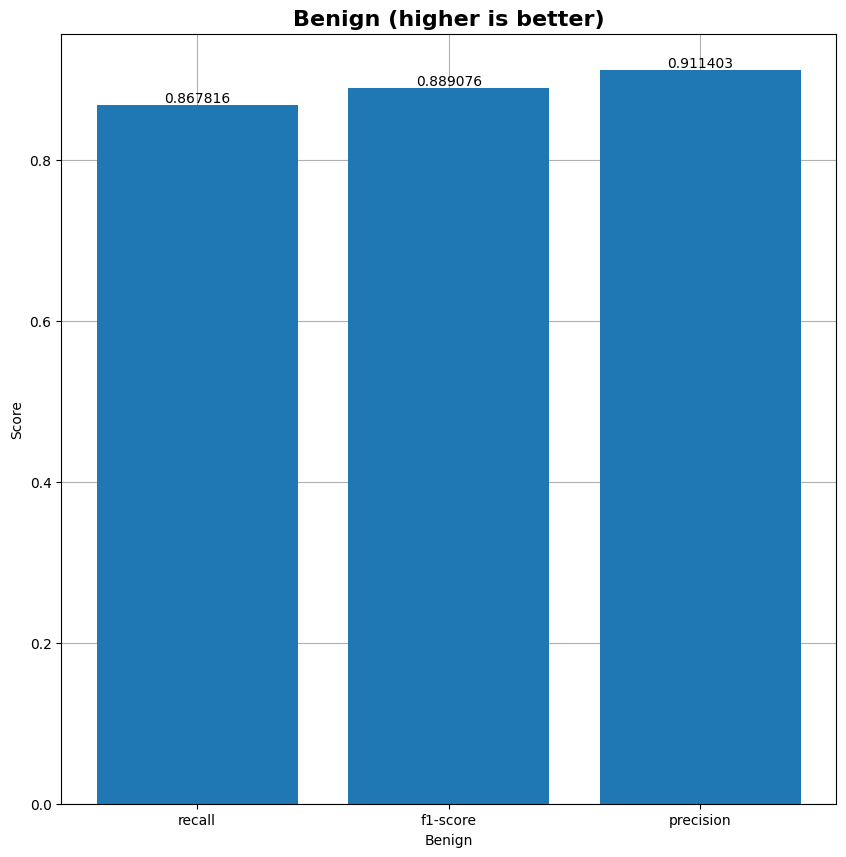

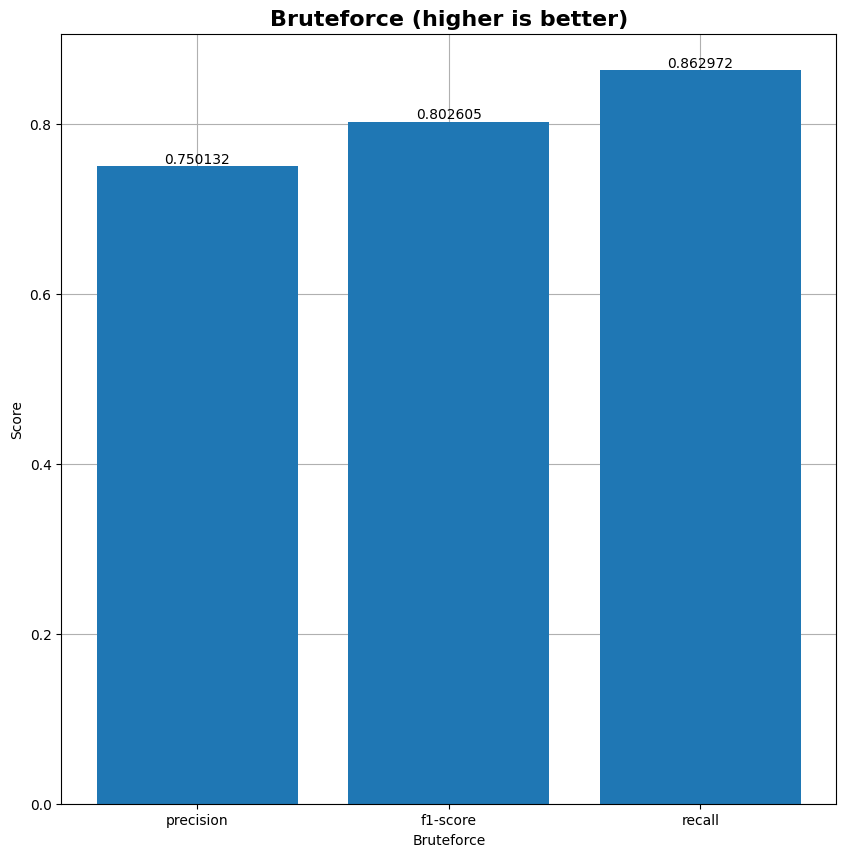

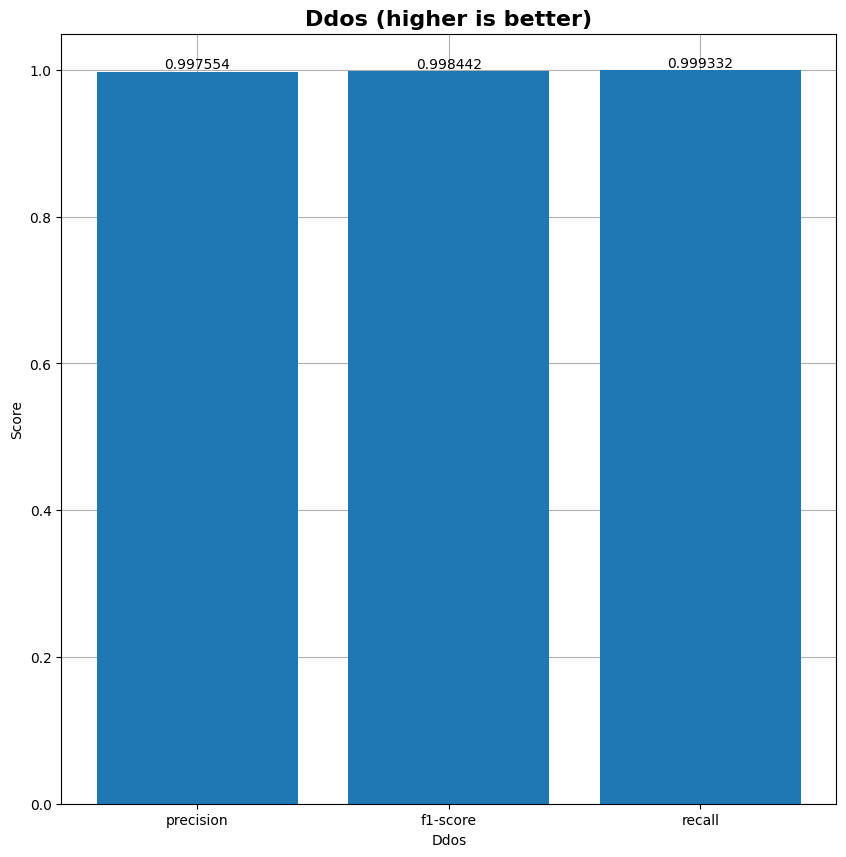

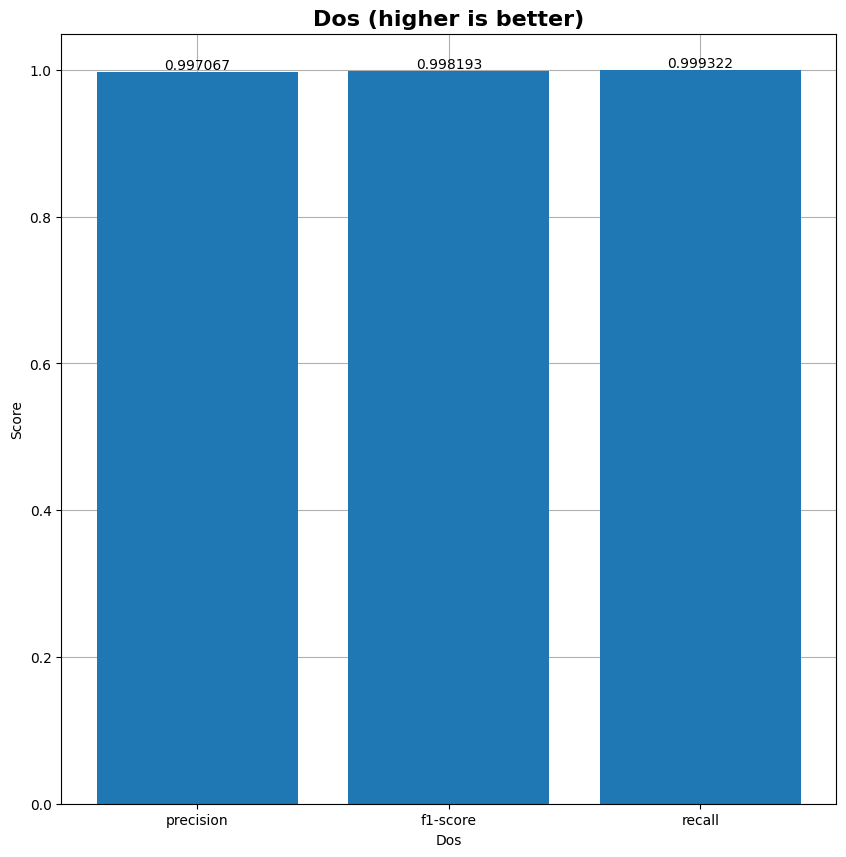

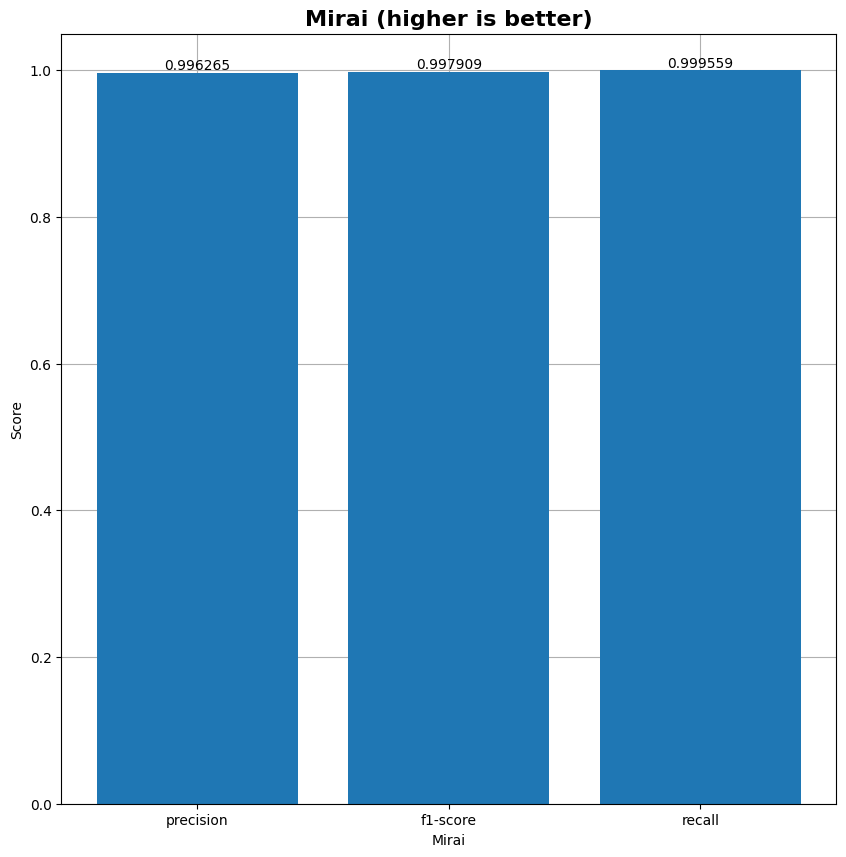

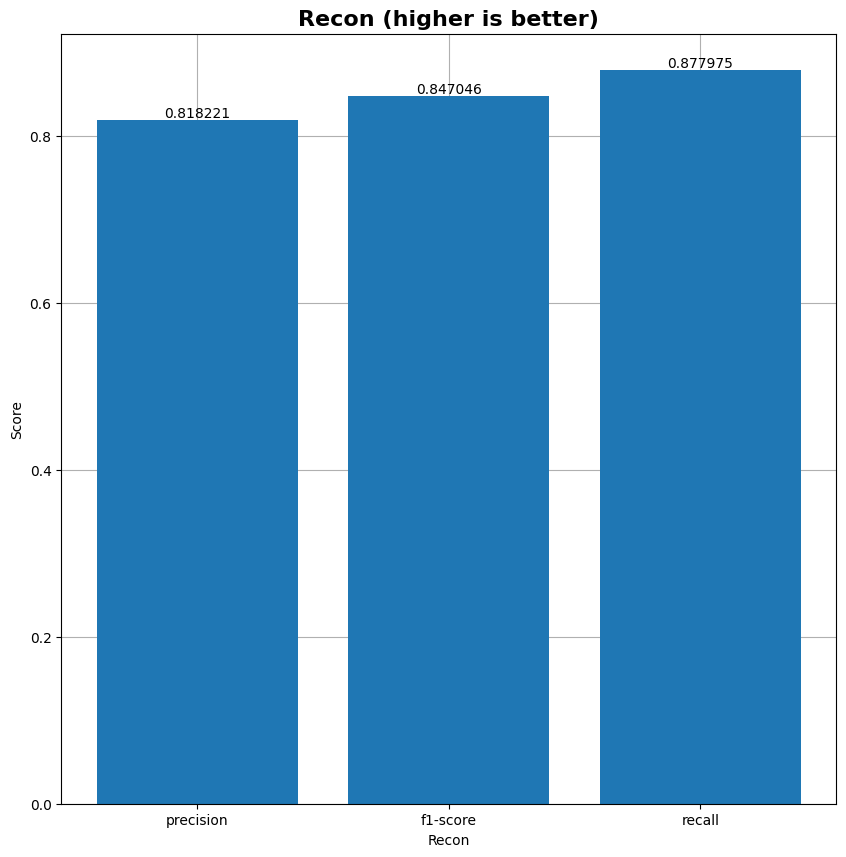

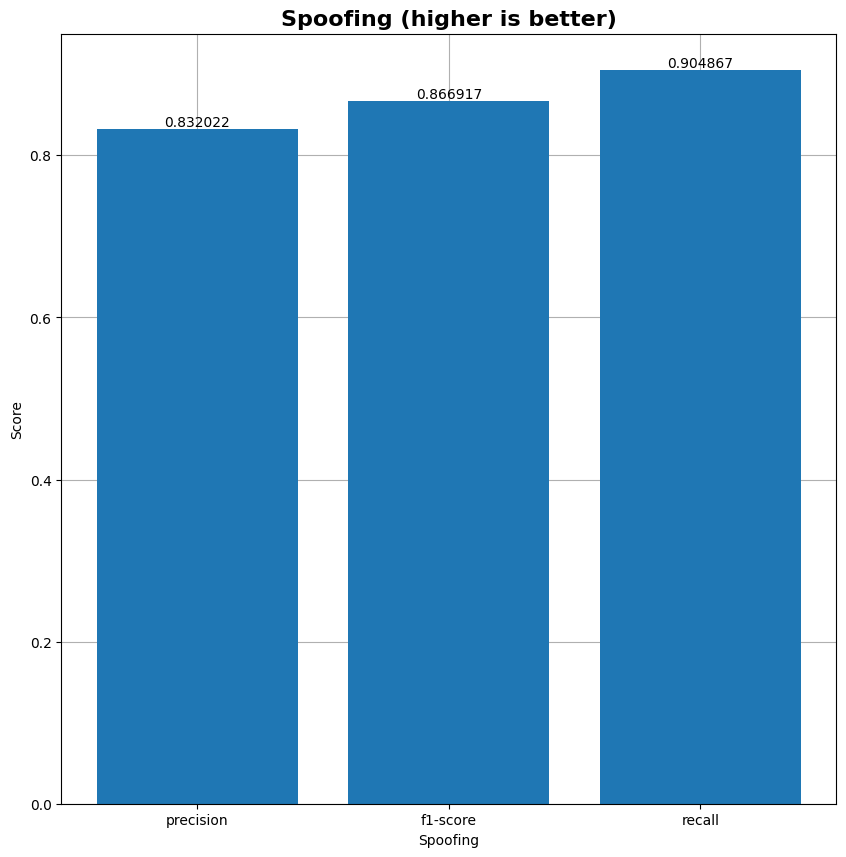

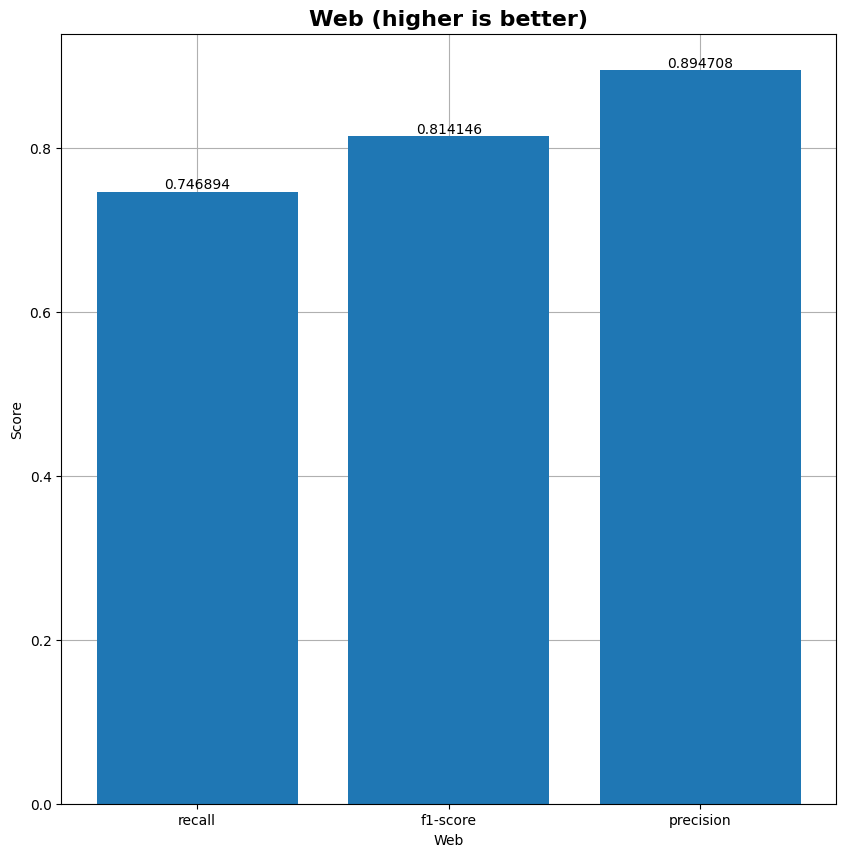

In [32]:
plot_mc(y_pred, y_test, "RF")

# XGBoost

In [33]:
%%time

start = time.time()

xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

end = time.time()

XGB_time = end - start

CPU times: user 59.3 s, sys: 171 ms, total: 59.5 s
Wall time: 7.78 s


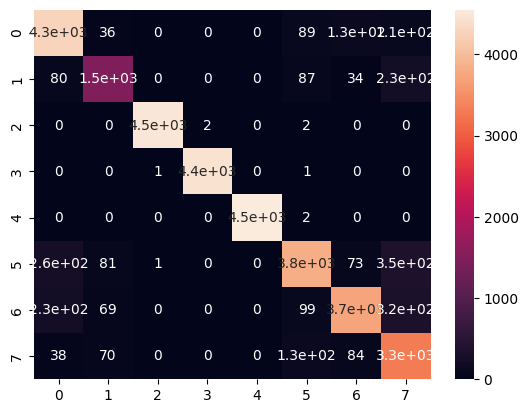

In [34]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [35]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [36]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, XGB_time]
results_dict["XGBoost"] = results

In [37]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.749908,0.753848,0.749968,0.749908,0.712982,0.906284,4.565078,2.136604,9.339322
LR,0.673479,0.682574,0.666665,0.673479,0.626146,1.012544,4.725921,2.173918,1056.777531
RF,0.911608,0.914864,0.911837,0.911608,0.898712,0.318872,1.569942,1.252973,11.841325
XGBoost,0.920328,0.923332,0.920494,0.920328,0.908756,0.291519,1.443091,1.201287,7.775450


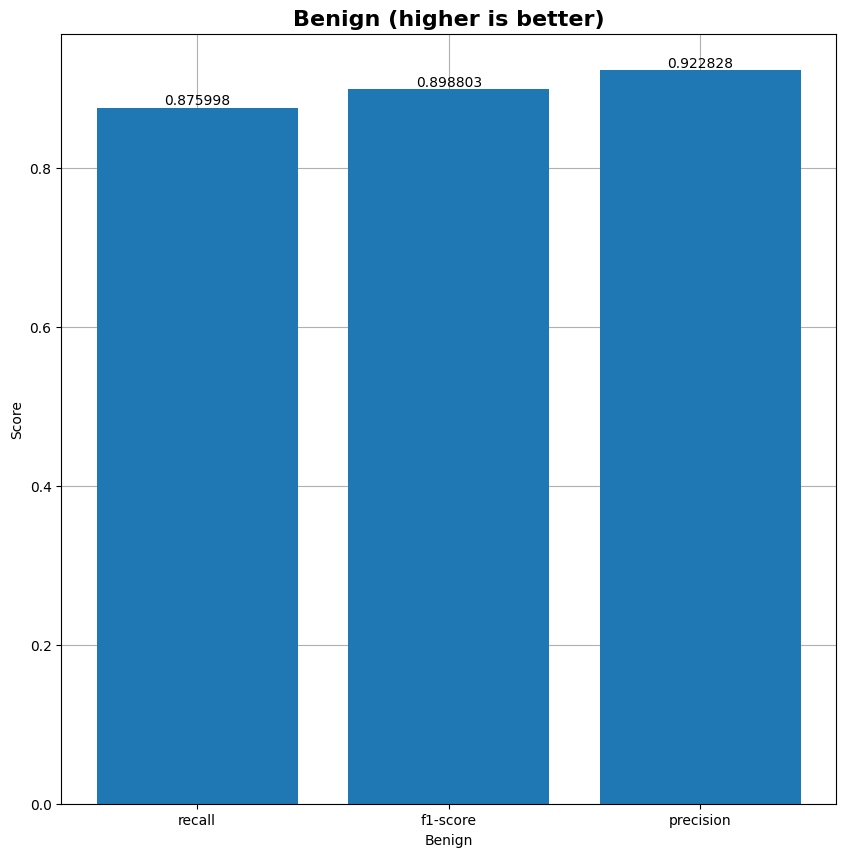

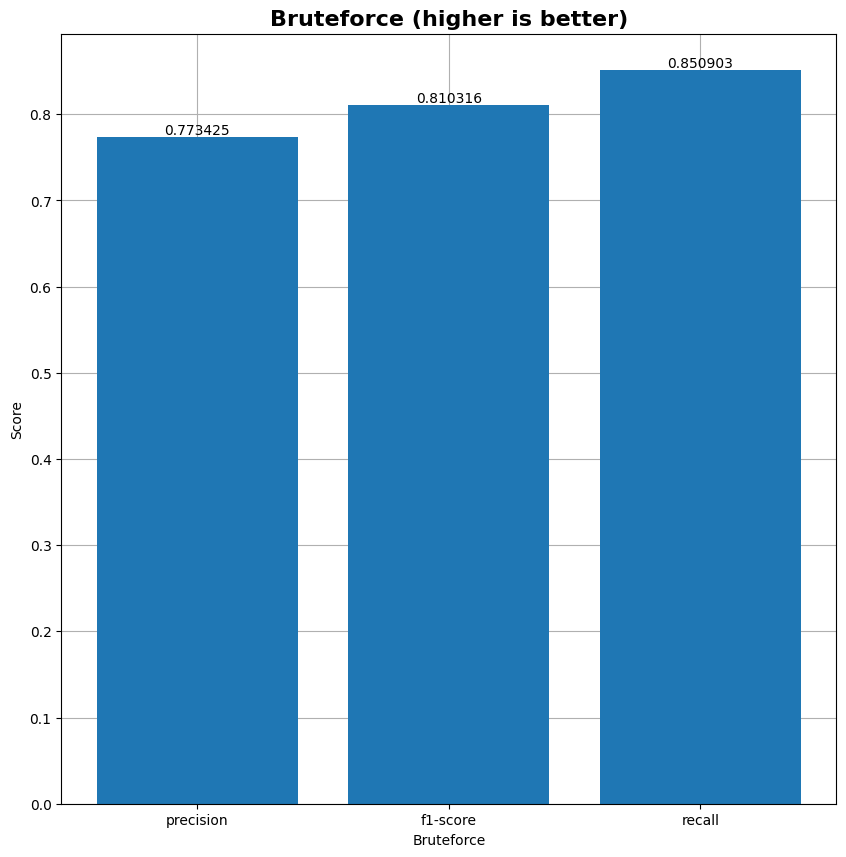

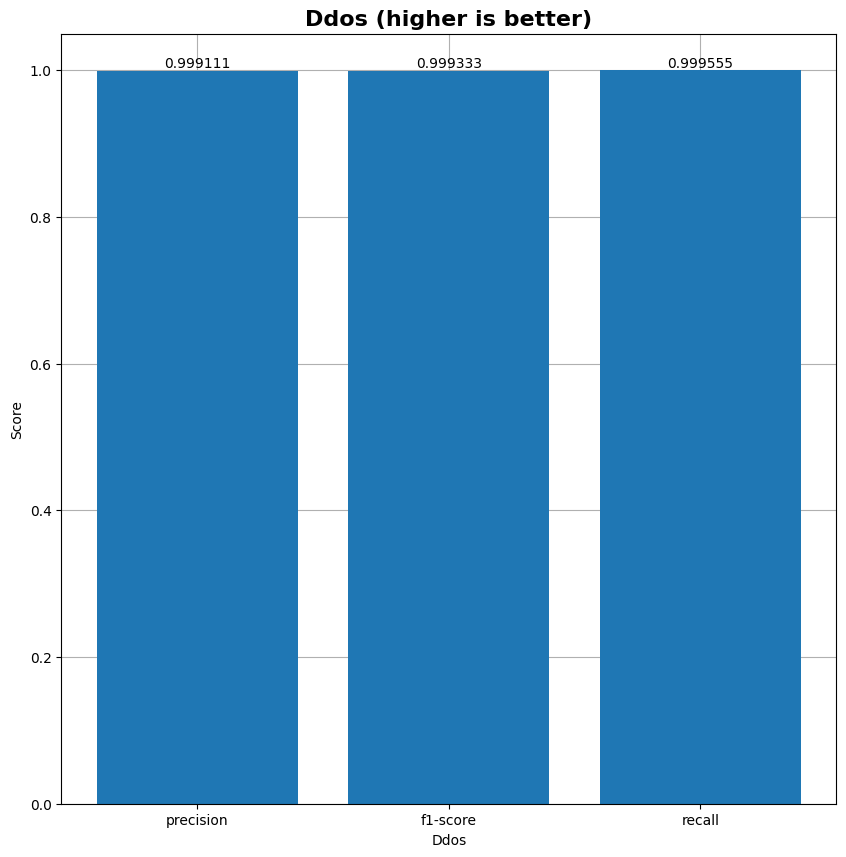

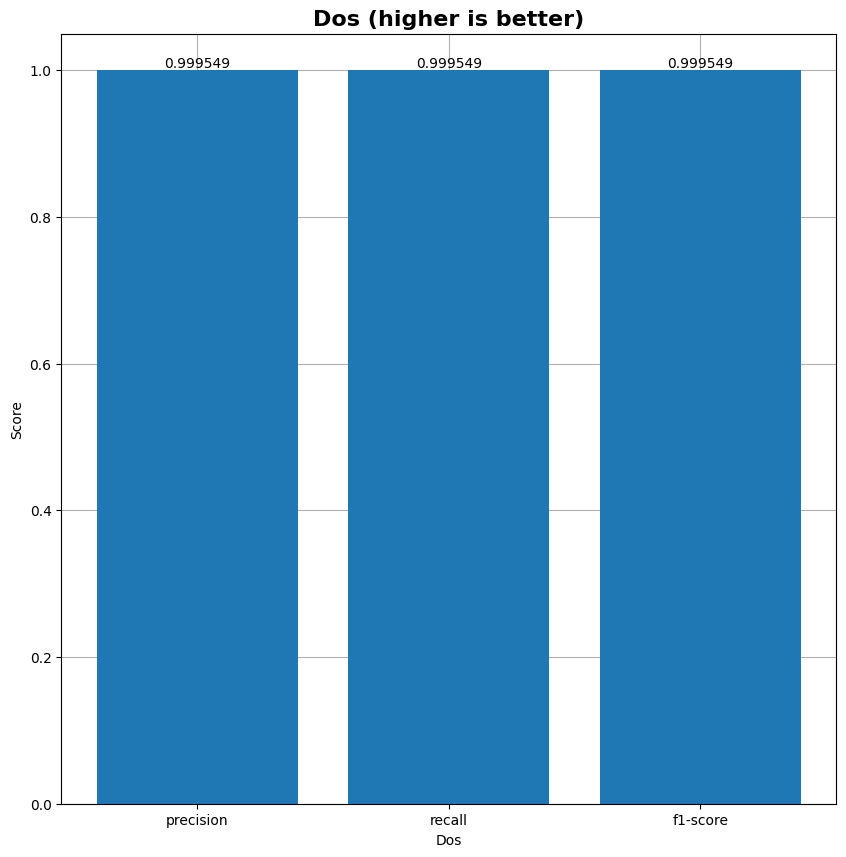

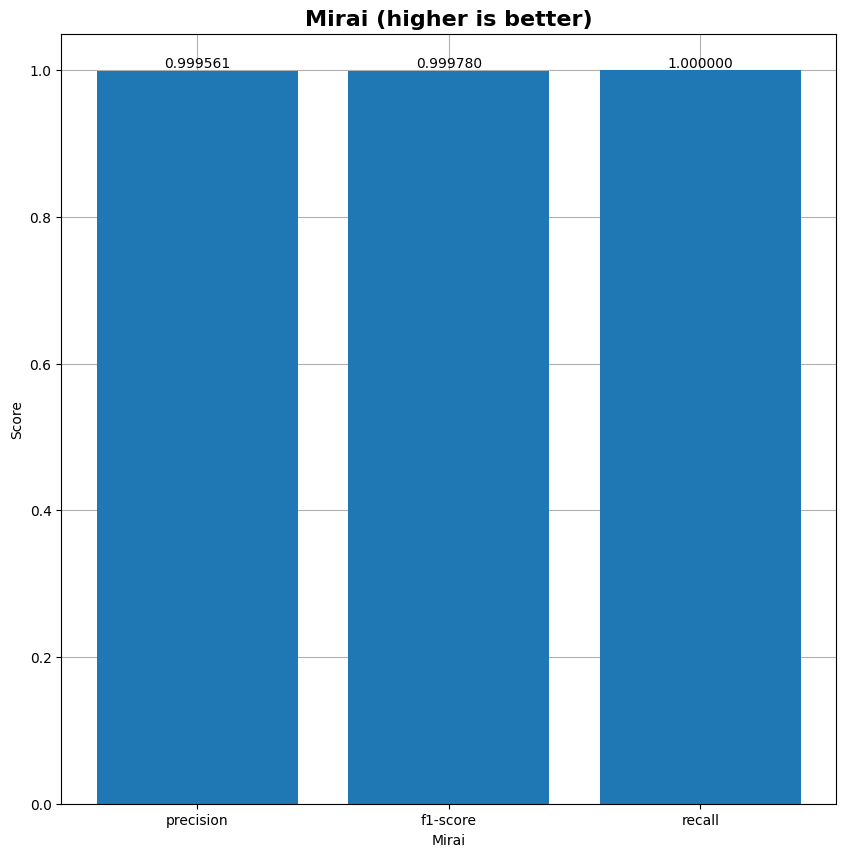

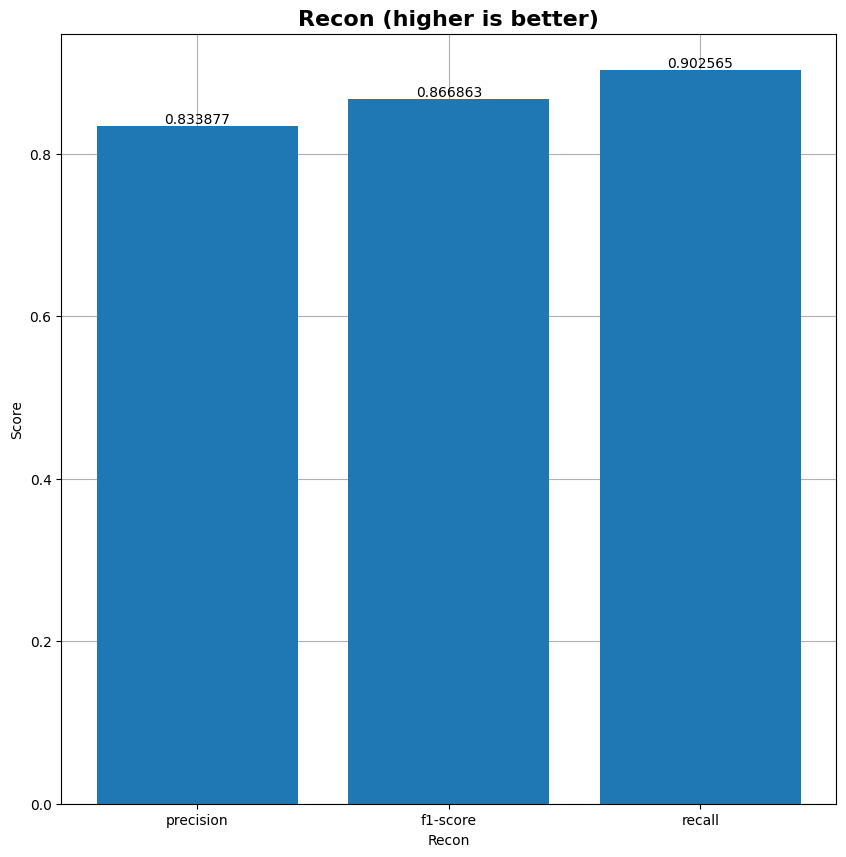

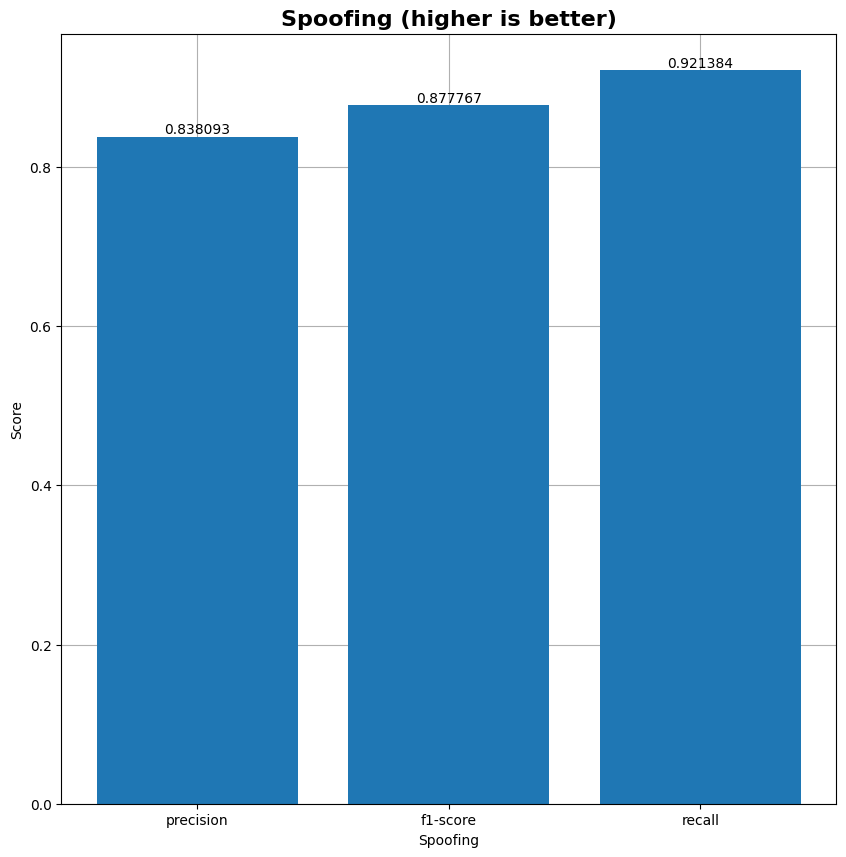

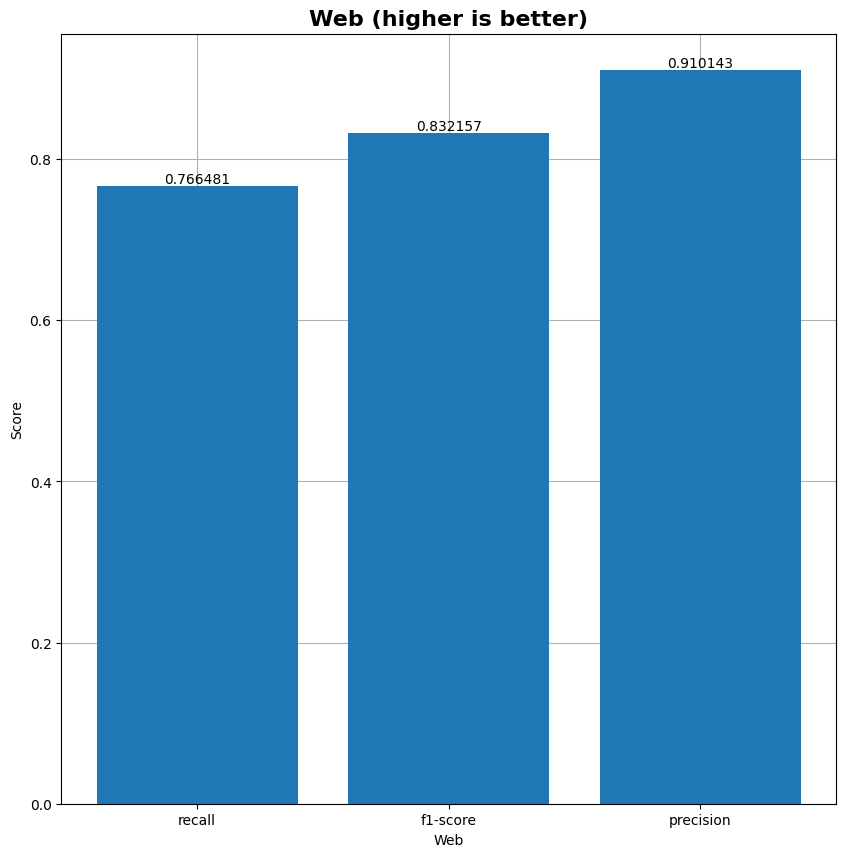

In [38]:
plot_mc(y_pred, y_test, "XGBoost")

# LightGBM

In [39]:
%%time

start = time.time()

lgbm_clf = lightgbm.LGBMClassifier()
lgbm_clf.fit(X_train, y_train)
y_pred = lgbm_clf.predict(X_test)

end = time.time()

LightGBM_Time = end - start

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5335
[LightGBM] [Info] Number of data points in the train set: 185209, number of used features: 39
[LightGBM] [Info] Start training from score -1.988272
[LightGBM] [Info] Start training from score -2.807806
[LightGBM] [Info] Start training from score -1.982728
[LightGBM] [Info] Start training from score -1.980182
[LightGBM] [Info] Start training from score -1.984808
[LightGBM] [Info] Start training from score -1.986696
[LightGBM] [Info] Start training from score -1.980730
[LightGBM] [Info] Start training from score -2.167437


/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


CPU times: user 25.1 s, sys: 152 ms, total: 25.3 s
Wall time: 6.47 s


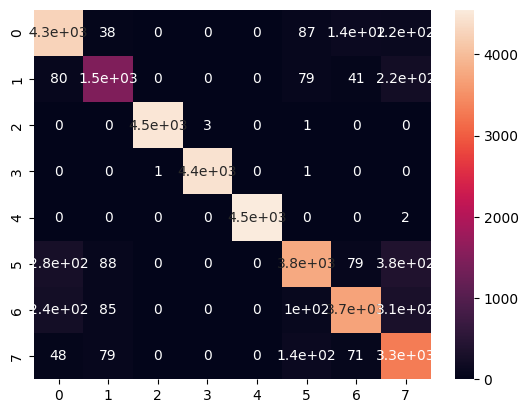

In [40]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [41]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [42]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, LightGBM_Time]
results_dict["LightGBM"] = results

In [43]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.749908,0.753848,0.749968,0.749908,0.712982,0.906284,4.565078,2.136604,9.339322
LR,0.673479,0.682574,0.666665,0.673479,0.626146,1.012544,4.725921,2.173918,1056.777531
RF,0.911608,0.914864,0.911837,0.911608,0.898712,0.318872,1.569942,1.252973,11.841325
XGBoost,0.920328,0.923332,0.920494,0.920328,0.908756,0.291519,1.443091,1.201287,7.775450
LightGBM,0.917483,0.920643,0.917664,0.917483,0.905523,0.307306,1.532432,1.237914,6.472799


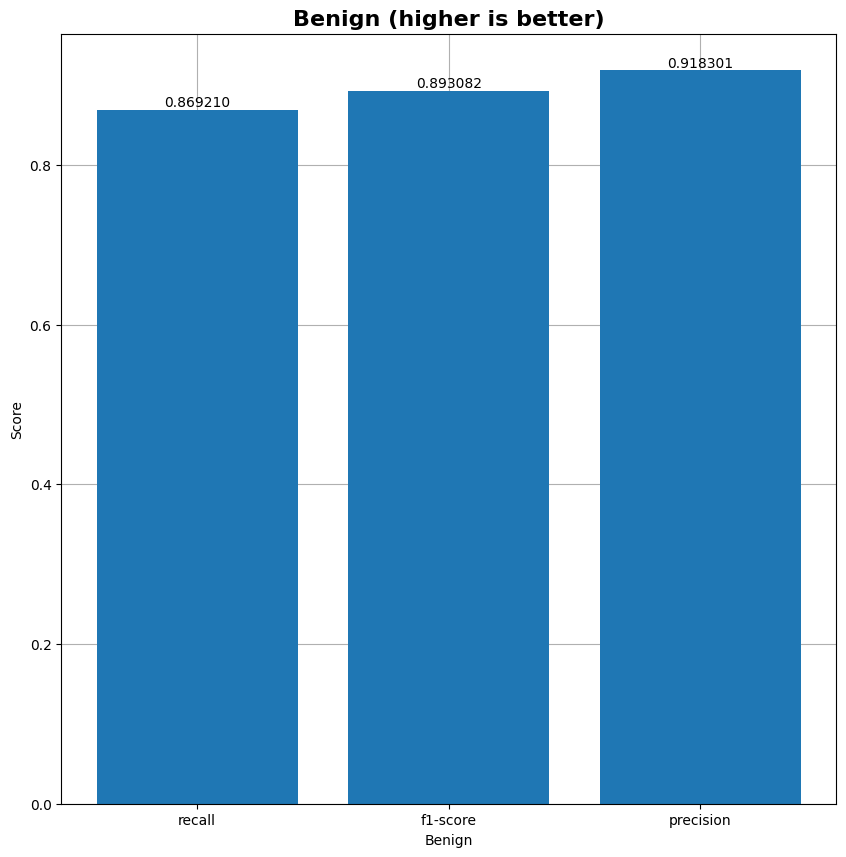

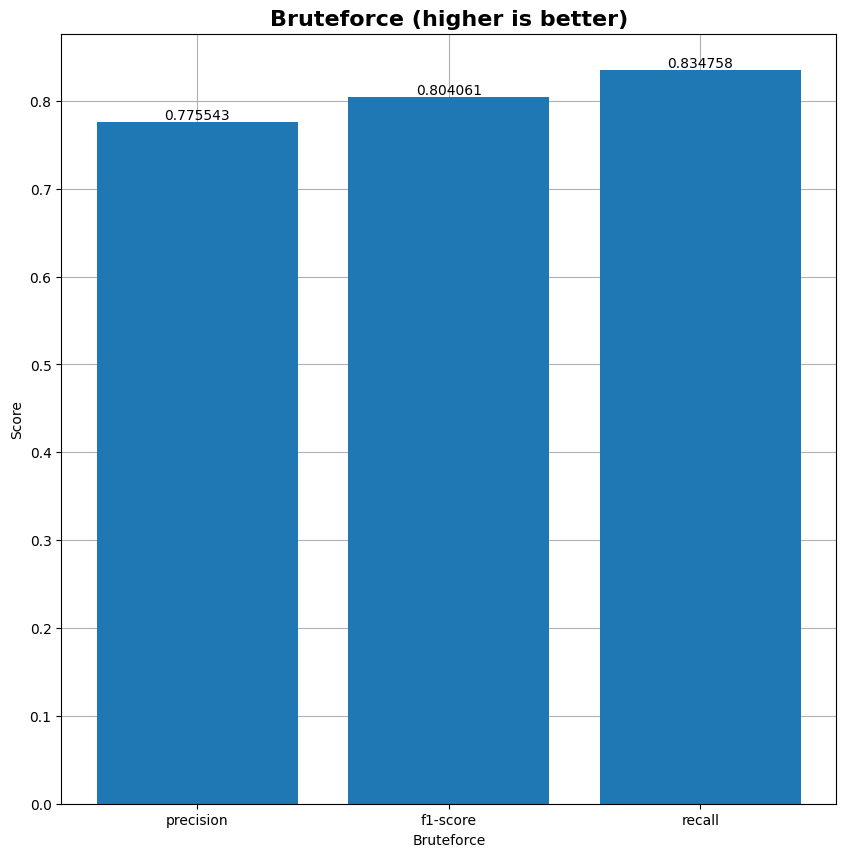

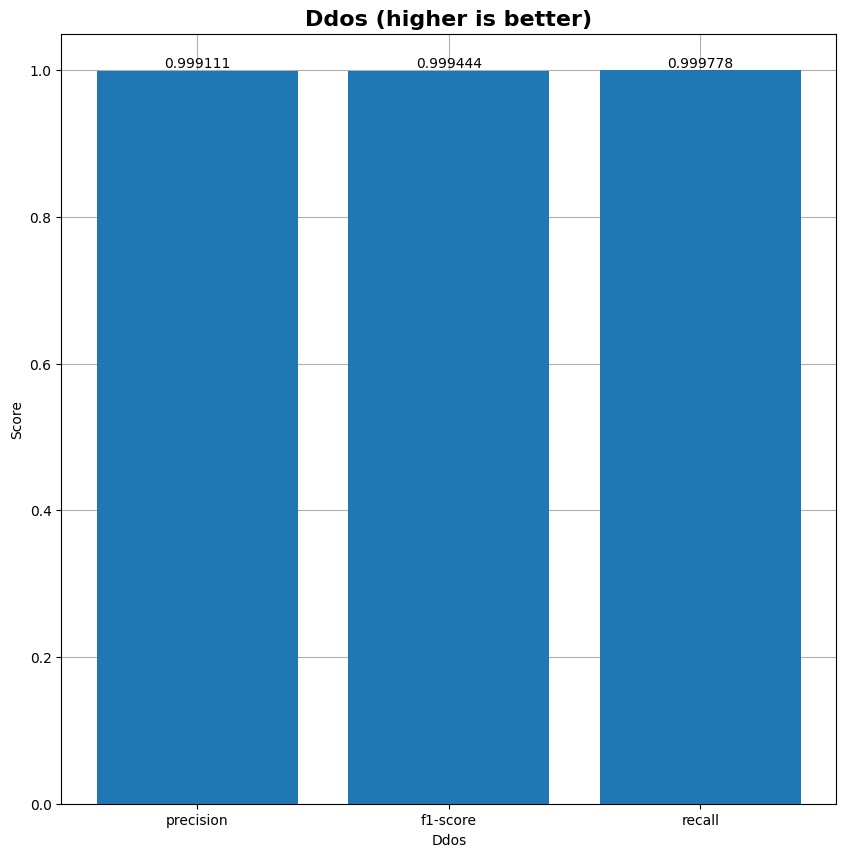

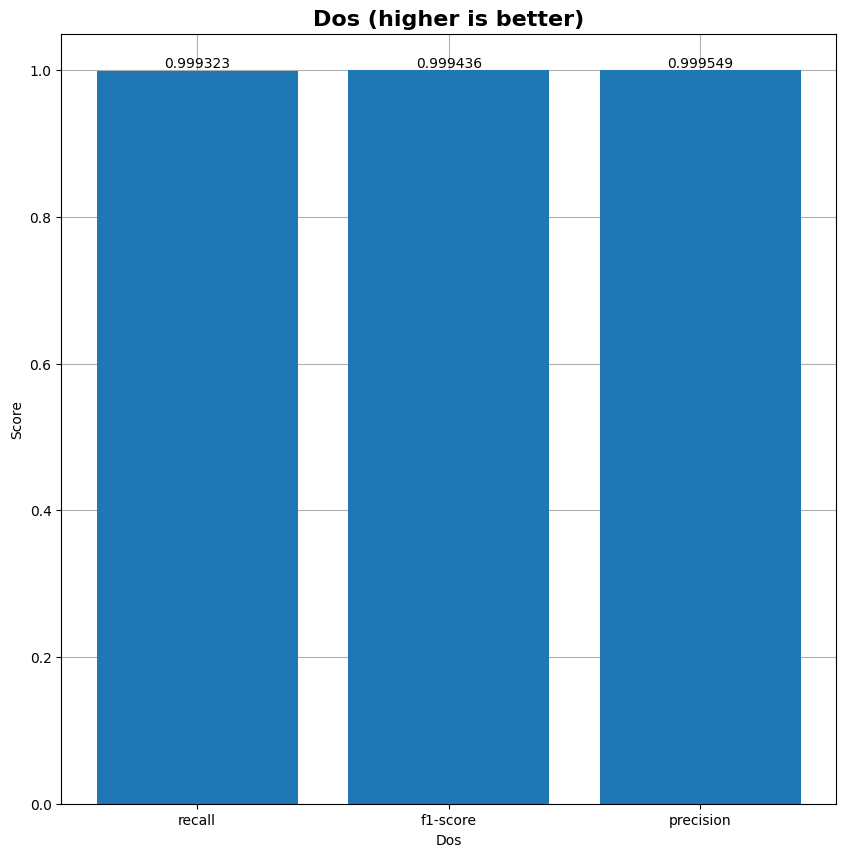

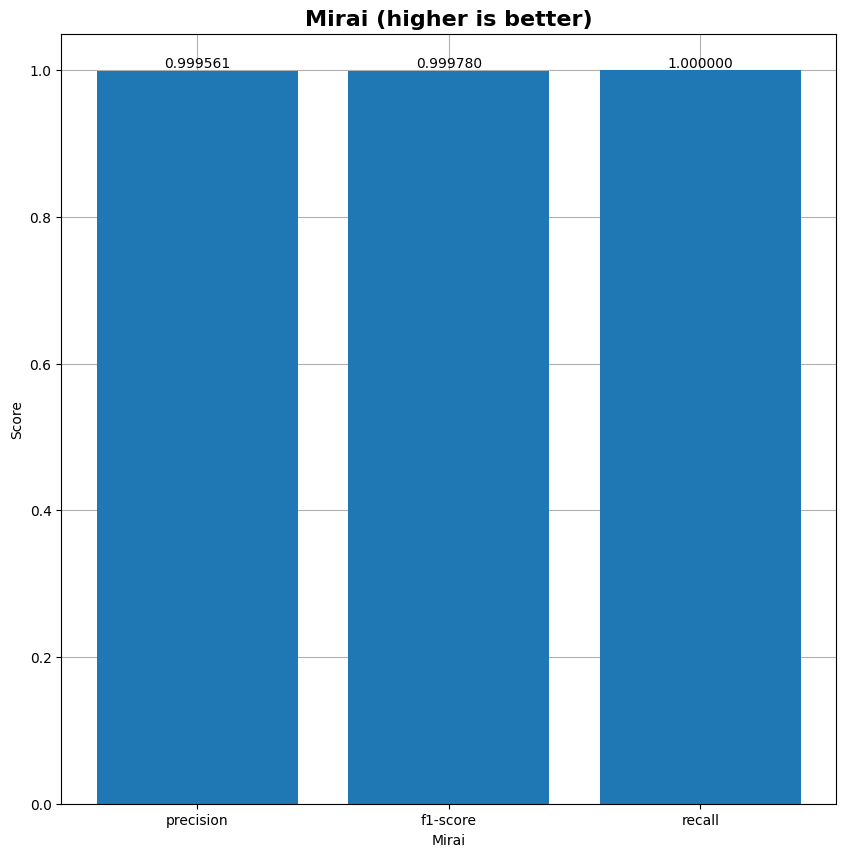

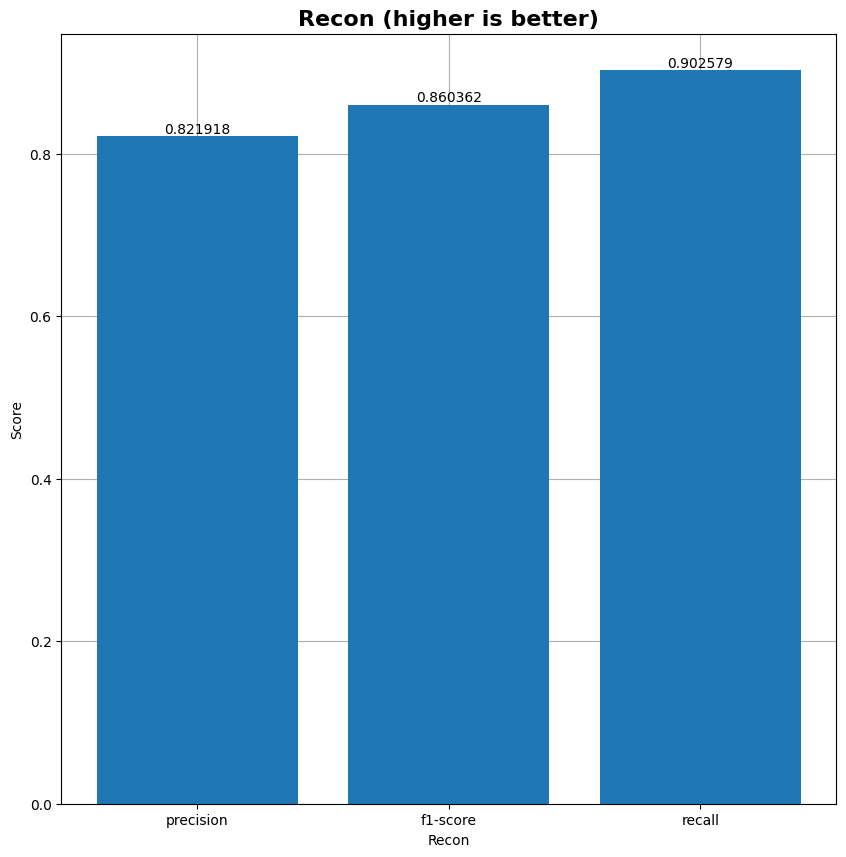

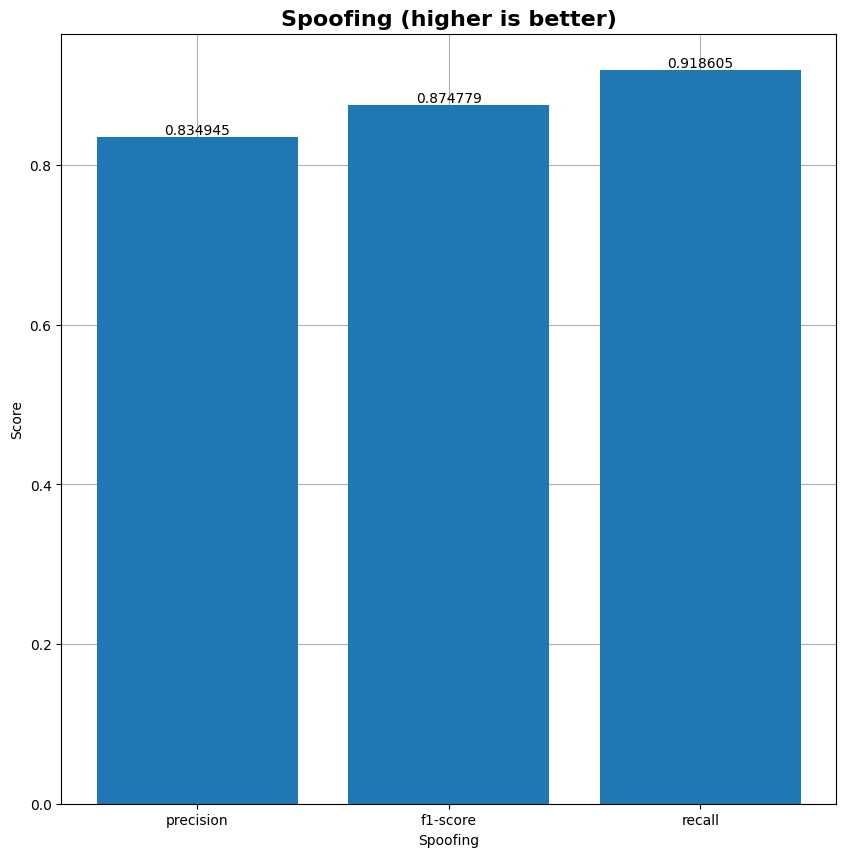

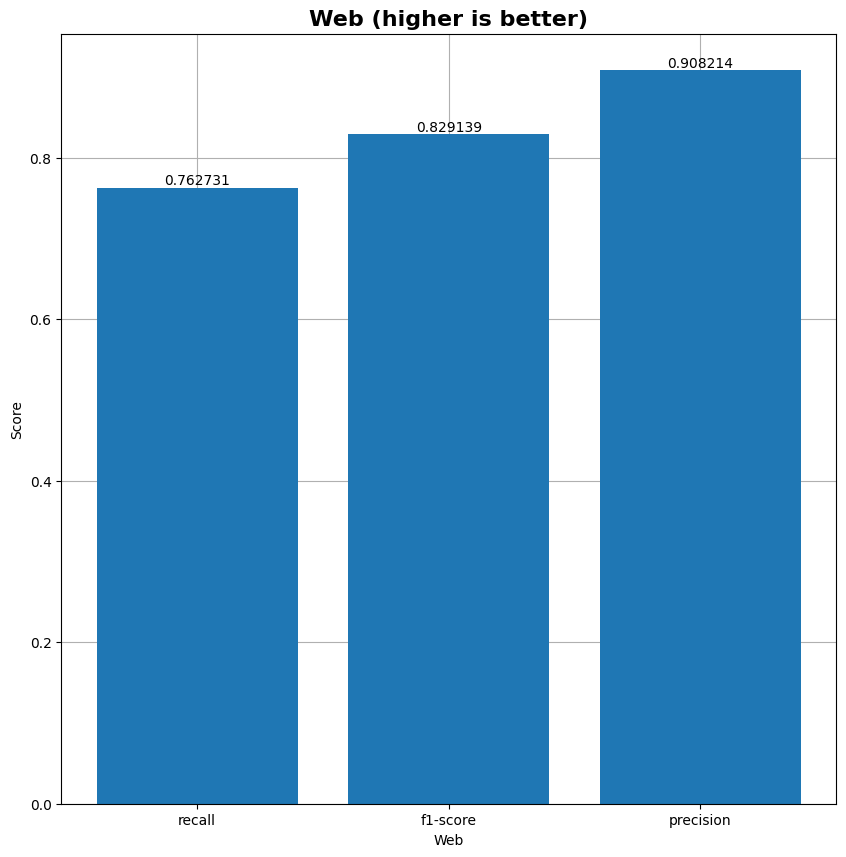

In [44]:
plot_mc(y_pred, y_test, "LightGBM")

# Feed Forward Neural Network

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((151871, 46), (151871,), (33338, 46), (33338,), (32684, 46), (32684,))

In [46]:
def create_model(X_train, y_train):
    model = keras.Sequential()
    model.add(keras.layers.Dense(X_train.shape[1], activation='relu', input_shape=(X_train.shape[1],)))
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dense(len(np.unique(y_train)), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
model = create_model(X_train, y_train)

/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1744131072.631160  117285 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2300 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1


In [47]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 46)             │         2,162 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │        48,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 579,194 (2.21 MB)

 Trainable params: 579,194 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
%%time

start = time.time()

model.fit(X_train, y_train,
          batch_size=16,
          epochs=20,
          validation_data=(X_val, y_val))
gc.collect();

y_pred = model.predict(X_test)

end = time.time()

FFNN_Time = end - start

Epoch 1/20


I0000 00:00:1744131074.168955  138098 service.cc:152] XLA service 0x7073ec00dab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744131074.168971  138098 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1060, Compute Capability 6.1
2025-04-08 19:51:14.196875: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744131074.374318  138098 cuda_dnn.cc:529] Loaded cuDNN version 90300


  69/9492 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.4605 - loss: 1.4351   

I0000 00:00:1744131075.254892  138098 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9492/9492 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.6759 - loss: 0.7844 - val_accuracy: 0.7221 - val_loss: 0.6506
Epoch 2/20
9492/9492 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.7325 - loss: 0.6373 - val_accuracy: 0.7378 - val_loss: 0.6223
Epoch 3/20
9492/9492 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.7440 - loss: 0.6104 - val_accuracy: 0.7431 - val_loss: 0.6045
Epoch 4/20
9492/9492 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.7528 - loss: 0.5895 - val_accuracy: 0.7482 - val_loss: 0.6017
Epoch 5/20
9492/9492 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.7583 - loss: 0.5795 - val_accuracy: 0.7580 - val_loss: 0.5818
Epoch 6/20
9492/9492 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.7608 - loss: 0.5708 - val_accuracy: 0.7574 - val_loss: 0.5812
Epoch 7/20
9492/9492 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.7641 - loss: 0.5634 - val_accuracy: 0.7572 - val_loss: 0.5746
Epoch 8/20
9492/9492 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.7670 - loss: 0.5599 - val

In [49]:
y_pred = np.argmax(y_pred, axis=1)

In [50]:
_, accuracy = model.evaluate(X_test, y_test)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

1022/1022 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7656 - loss: 0.5689


In [51]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, FFNN_Time]
results_dict["FF-NN"] = results

In [52]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.749908,0.753848,0.749968,0.749908,0.712982,0.906284,4.565078,2.136604,9.339322
LR,0.673479,0.682574,0.666665,0.673479,0.626146,1.012544,4.725921,2.173918,1056.777531
RF,0.911608,0.914864,0.911837,0.911608,0.898712,0.318872,1.569942,1.252973,11.841325
XGBoost,0.920328,0.923332,0.920494,0.920328,0.908756,0.291519,1.443091,1.201287,7.775450
LightGBM,0.917483,0.920643,0.917664,0.917483,0.905523,0.307306,1.532432,1.237914,6.472799
FF-NN,0.765604,0.783759,0.765423,0.765604,0.733587,0.721117,3.414117,1.847733,462.213329


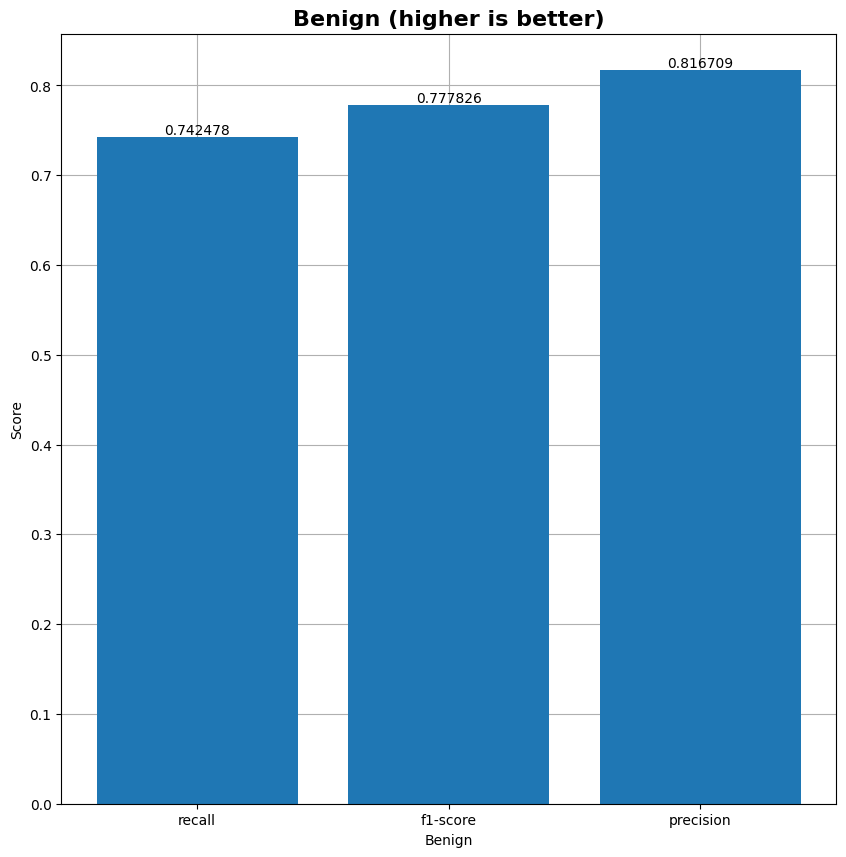

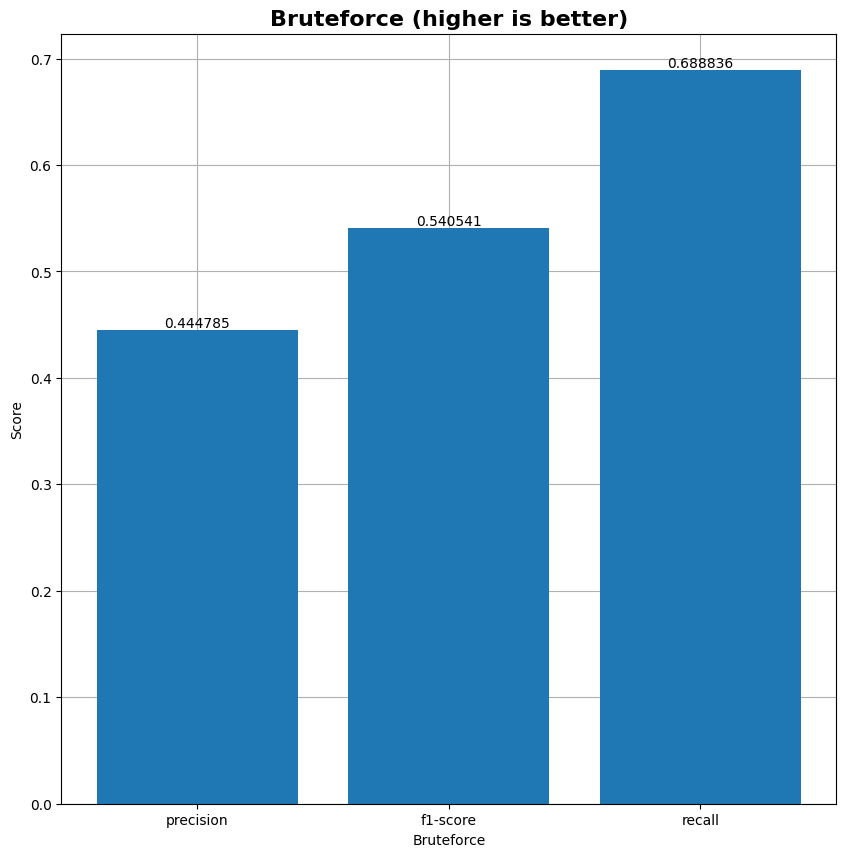

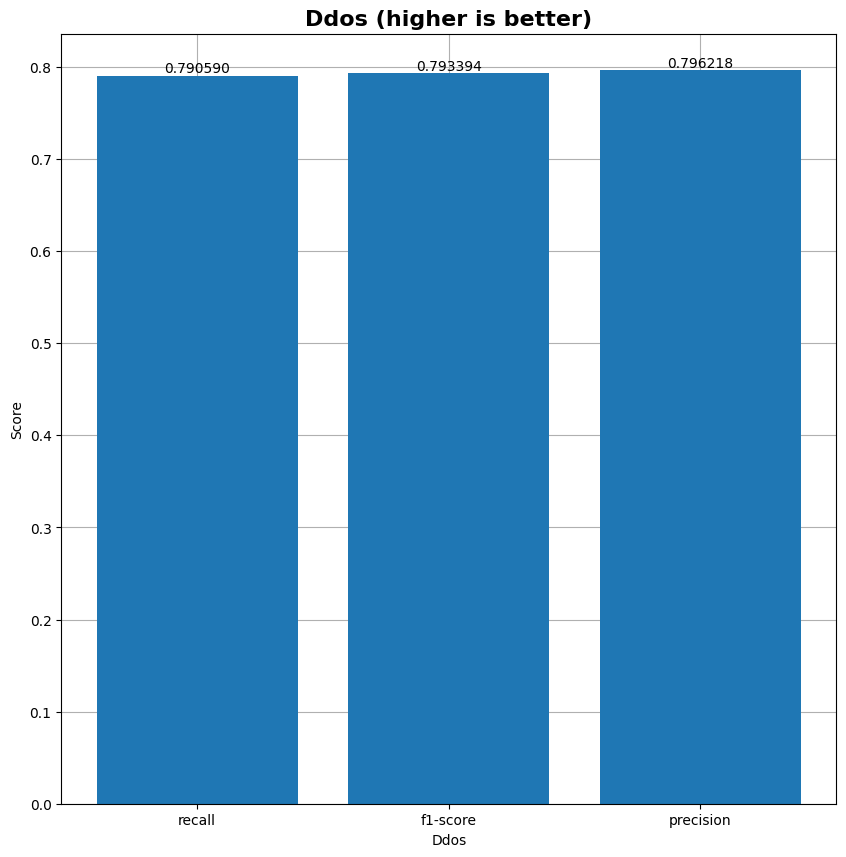

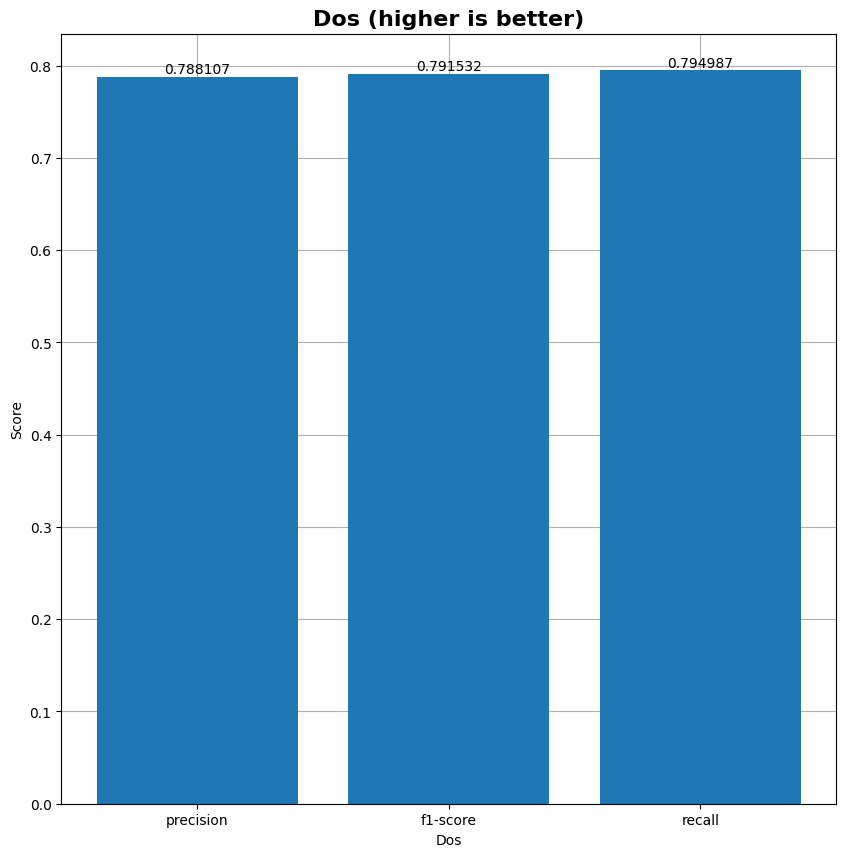

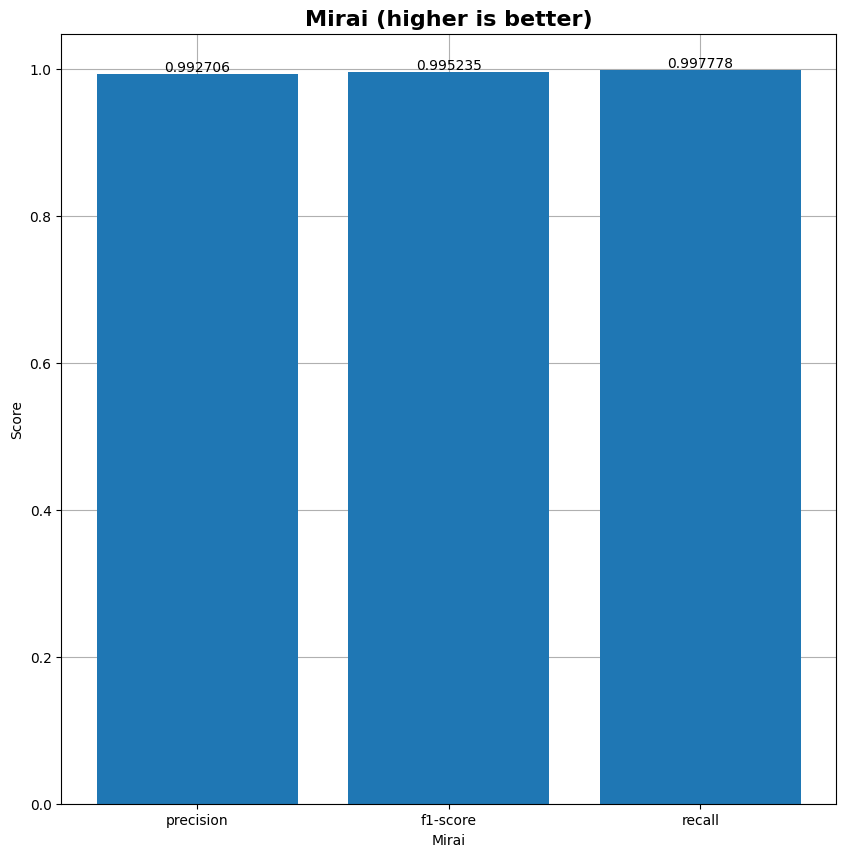

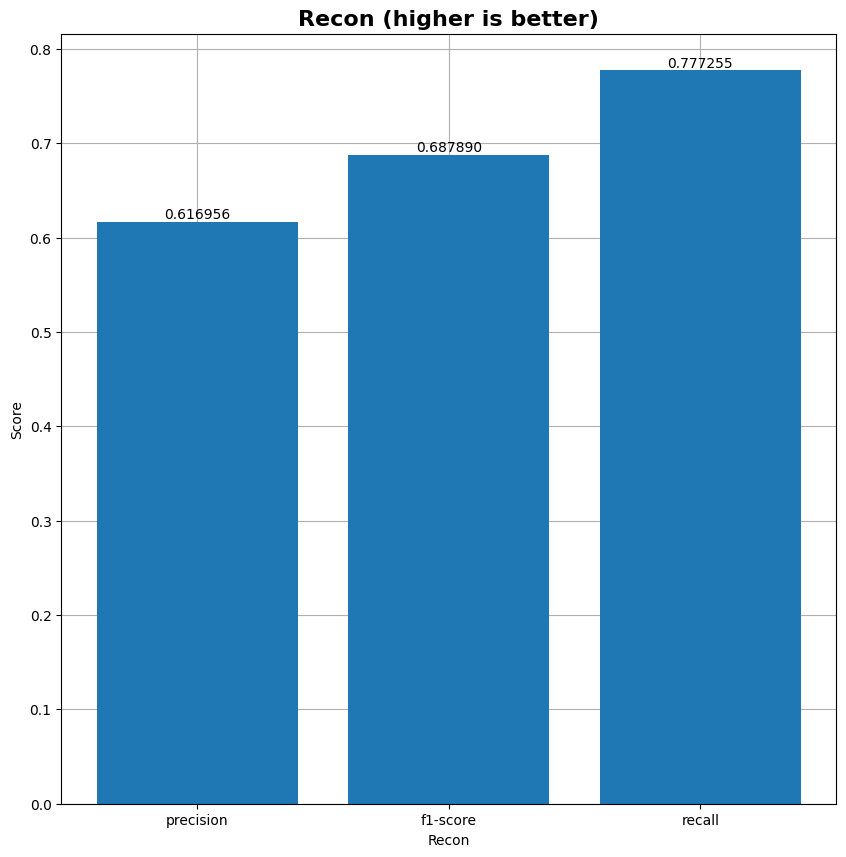

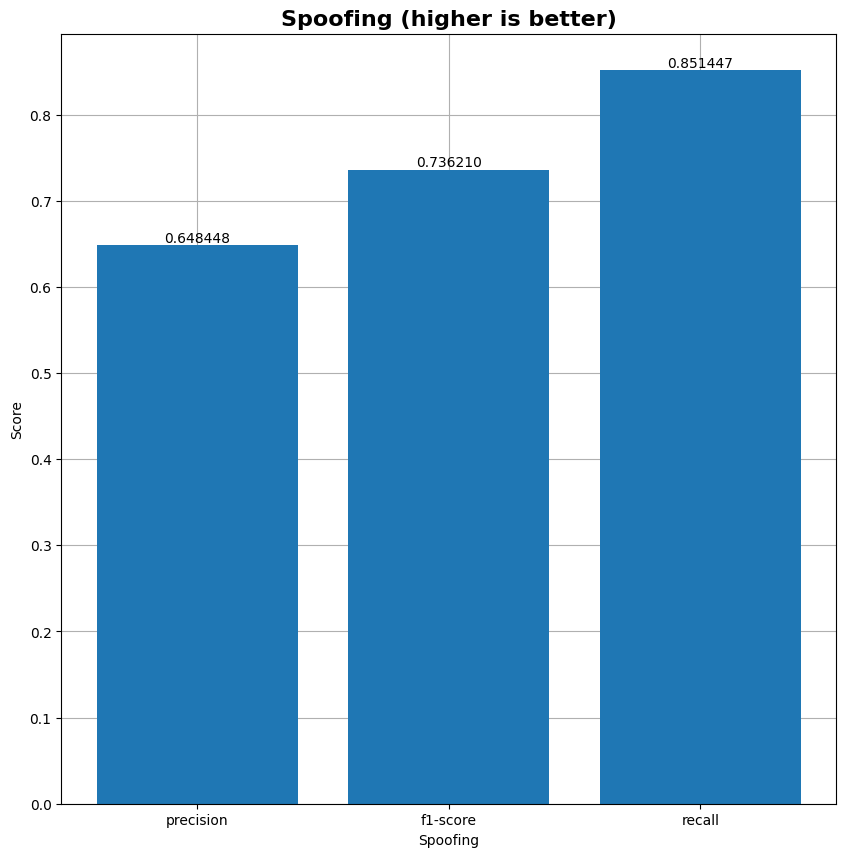

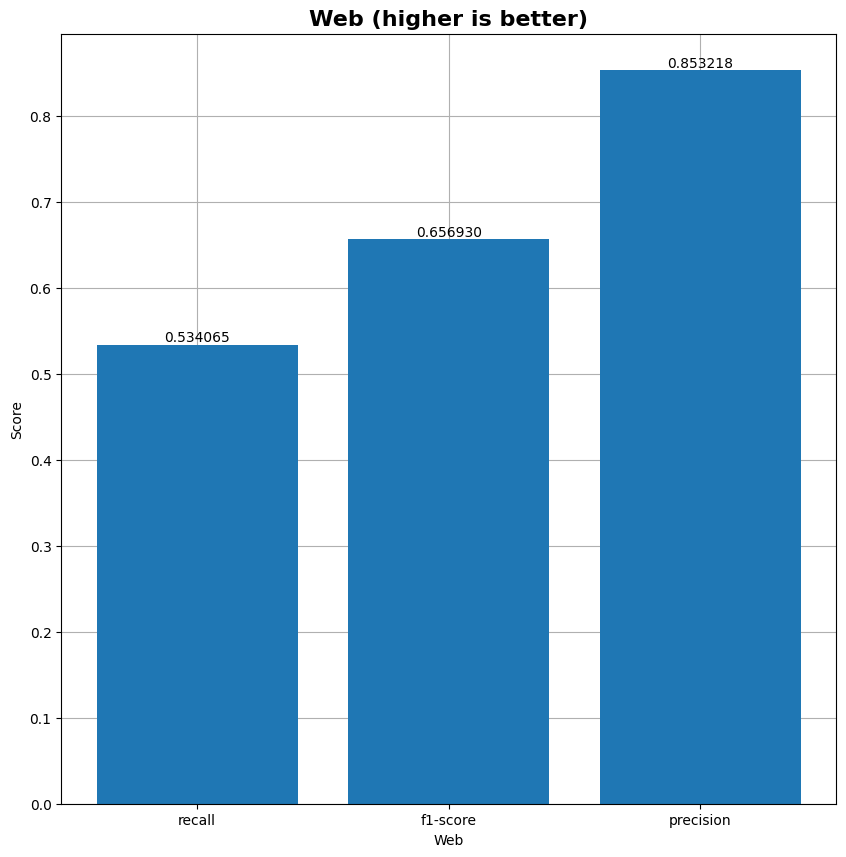

In [53]:
plot_mc(y_pred, y_test, "FF-NN")

# LSTM

In [54]:
# Prepare sequential data
def create_sequences(features, labels, seq_length):
    sequences, seq_labels = [], []
    for i in range(len(features) - seq_length):
        sequences.append(features[i:i + seq_length])
        seq_labels.append(labels[i + seq_length - 1])  # Use the last label in the sequence
    return np.array(sequences), np.array(seq_labels)

In [55]:
num_components = len(np.unique(y))

In [56]:
# Create sequences
seq_length = 20
X1, y1 = create_sequences(X, y, seq_length)
y1 = to_categorical(y1, num_classes=num_components)  # Convert labels to one-hot encoding

In [57]:
# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X1, y1, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [58]:
def create_model_LSTM(input_shape, num_classes):
    model = keras.Sequential([
        keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True),
        keras.layers.Dropout(0.3),
        keras.layers.LSTM(32),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')  # Use softmax for multi-class classification
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [59]:
# Build model
model = create_model_LSTM(input_shape=(seq_length, X1.shape[2]), num_classes=num_components)

/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [60]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 64)         │        28,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,464 (169.78 KB)

 Trainable params: 43,464 (169.78 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
%%time

start = time.time()

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

# Evaluate model
y_pred = model.predict(X_test)

end = time.time()

LSTM_Time = end - start

Epoch 1/10
4766/4766 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - accuracy: 0.9695 - loss: 0.1227 - val_accuracy: 0.9972 - val_loss: 0.0123
Epoch 2/10
4766/4766 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.9987 - loss: 0.0058 - val_accuracy: 0.9993 - val_loss: 0.0026
Epoch 3/10
4766/4766 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.9991 - loss: 0.0041 - val_accuracy: 0.9997 - val_loss: 0.0016
Epoch 4/10
4766/4766 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.9995 - loss: 0.0026 - val_accuracy: 0.9998 - val_loss: 9.5310e-04
Epoch 5/10
4766/4766 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.9997 - loss: 0.0016 - val_accuracy: 0.9998 - val_loss: 4.6846e-04
Epoch 6/10
4766/4766 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.9997 - loss: 0.0014 - val_accuracy: 0.9994 - val_loss: 0.0015
Epoch 7/10
4766/4766 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.9995 - loss: 0.0021 - val_accuracy: 0.9996 - val_loss: 0.0028
Epoch 8/10
4766/4766 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.9995 -

In [62]:
_, accuracy = model.evaluate(X_test, y_test)

1022/1022 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9999 - loss: 4.1803e-04


In [63]:
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

In [64]:
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [65]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, LSTM_Time]
results_dict["LSTM"] = results

In [66]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.749908,0.753848,0.749968,0.749908,0.712982,0.906284,4.565078,2.136604,9.339322
LR,0.673479,0.682574,0.666665,0.673479,0.626146,1.012544,4.725921,2.173918,1056.777531
RF,0.911608,0.914864,0.911837,0.911608,0.898712,0.318872,1.569942,1.252973,11.841325
XGBoost,0.920328,0.923332,0.920494,0.920328,0.908756,0.291519,1.443091,1.201287,7.775450
LightGBM,0.917483,0.920643,0.917664,0.917483,0.905523,0.307306,1.532432,1.237914,6.472799
FF-NN,0.765604,0.783759,0.765423,0.765604,0.733587,0.721117,3.414117,1.847733,462.213329
LSTM,0.999847,0.999847,0.999847,0.999847,0.999824,0.000459,0.002295,0.047905,308.995691


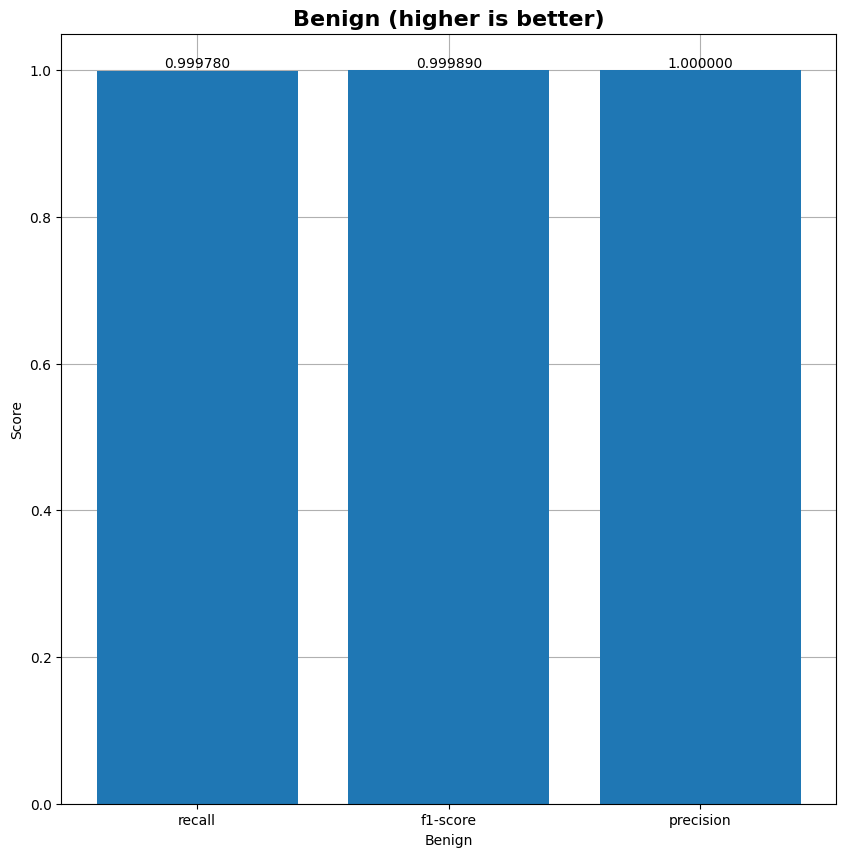

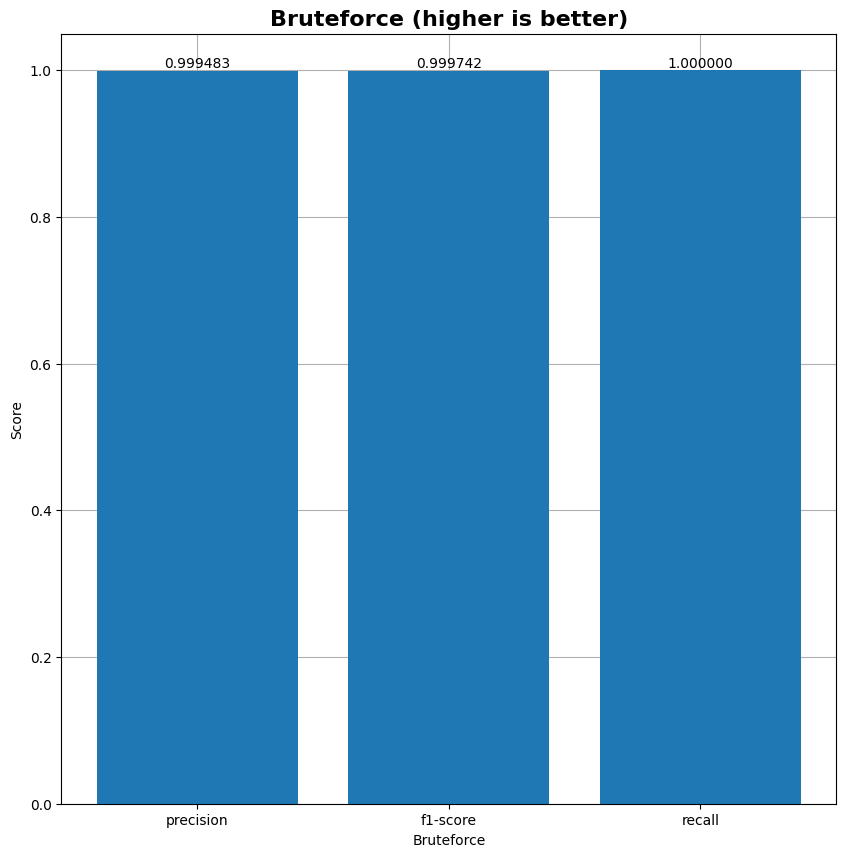

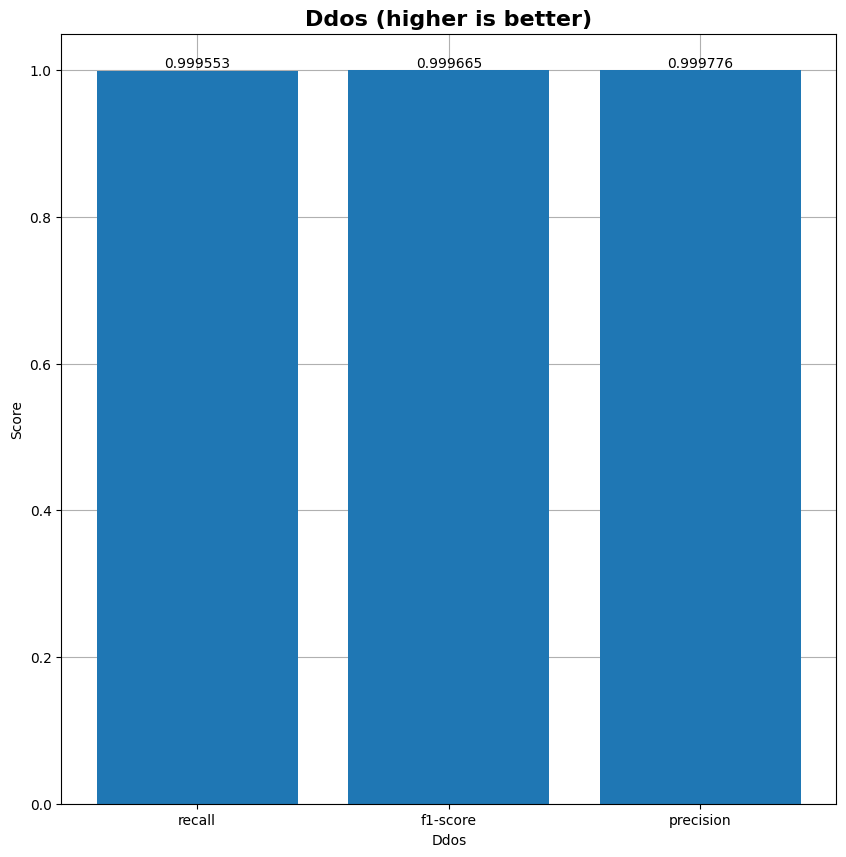

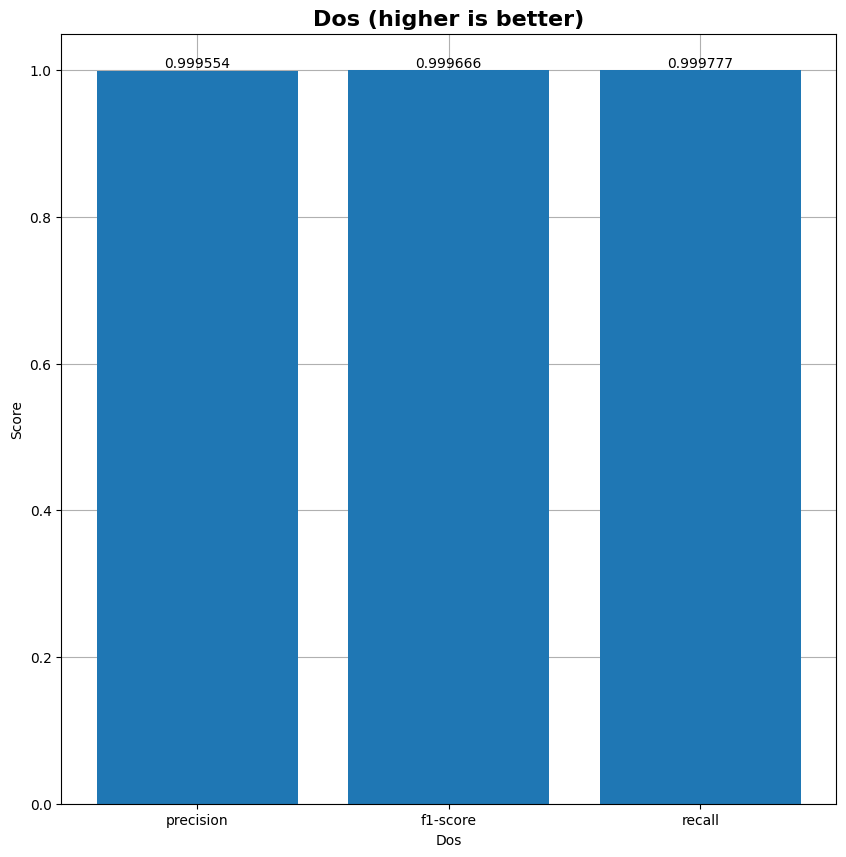

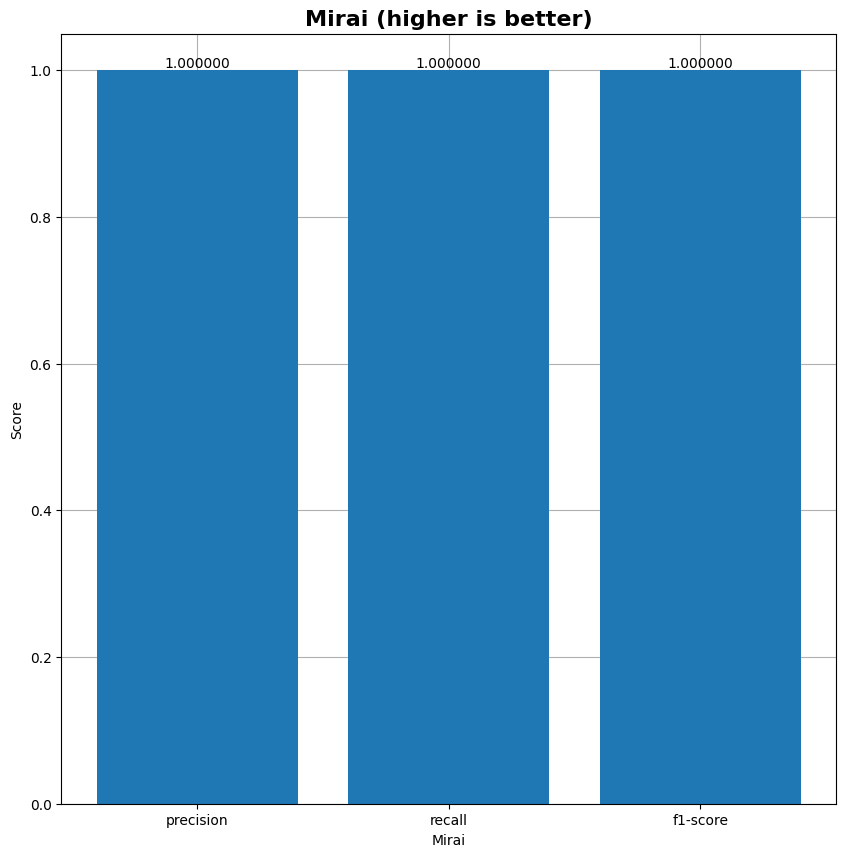

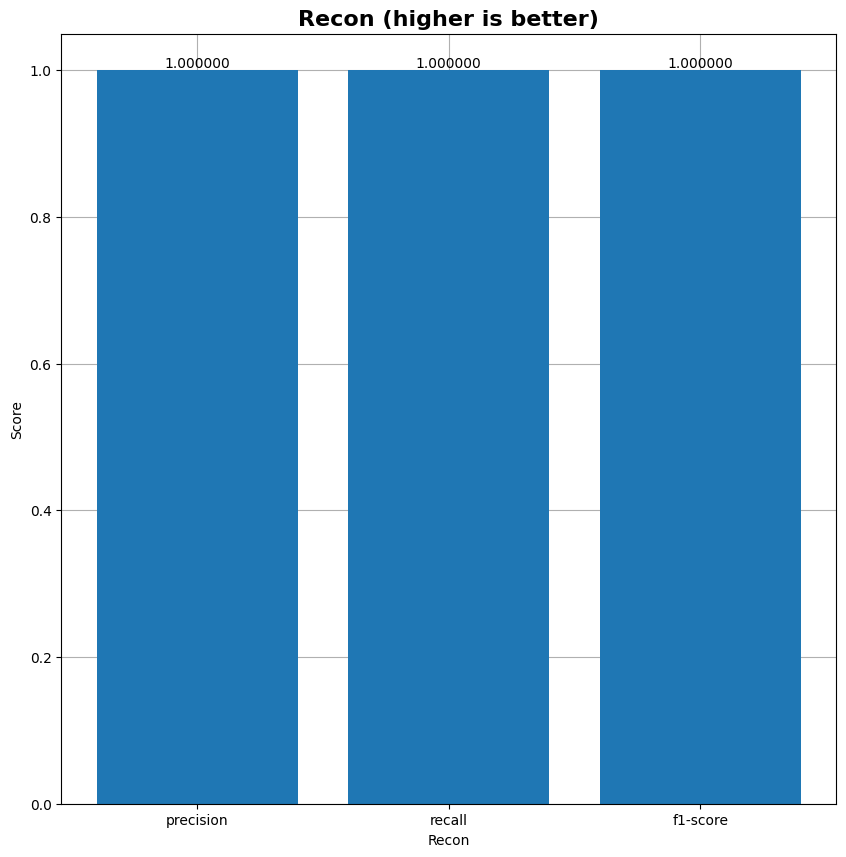

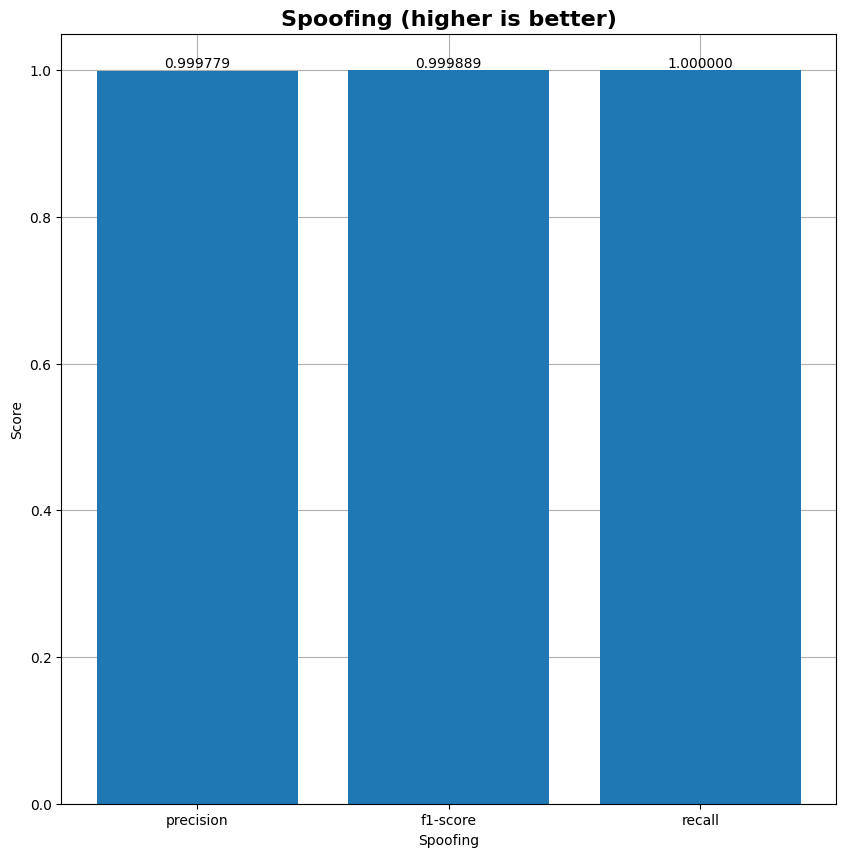

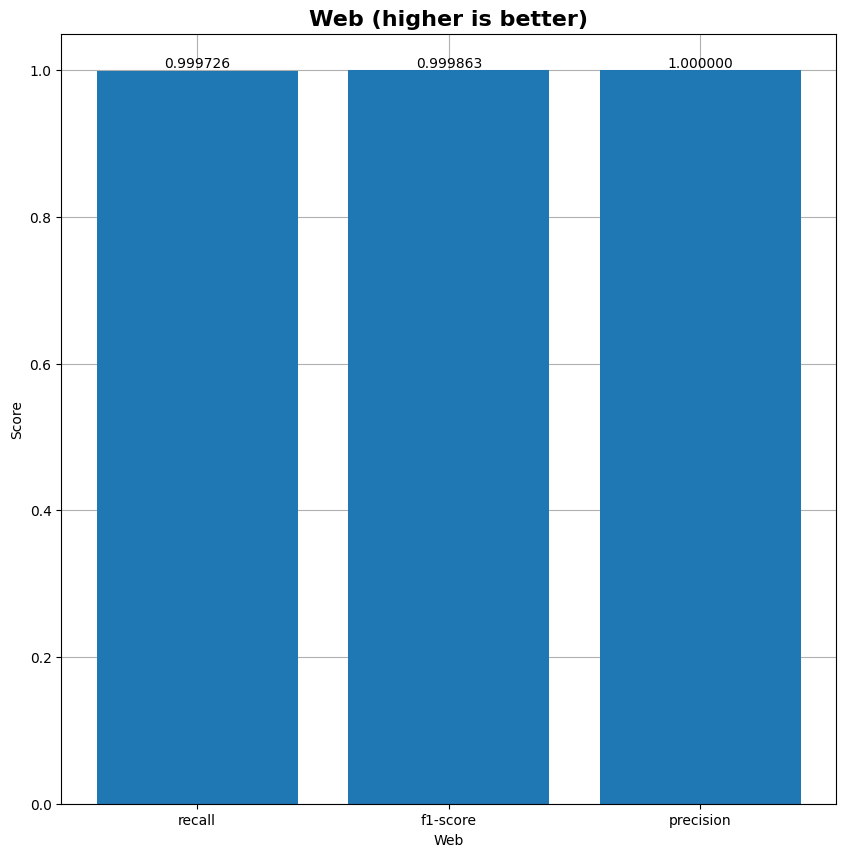

In [67]:
plot_mc(y_pred, y_test, "LSTM")

# Plot data

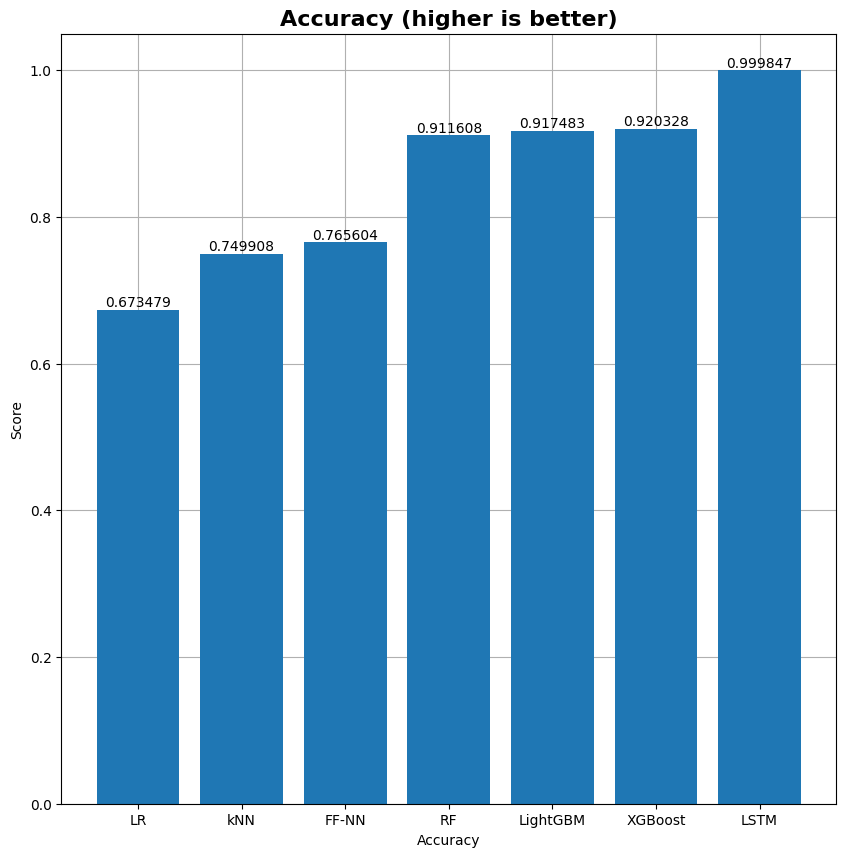

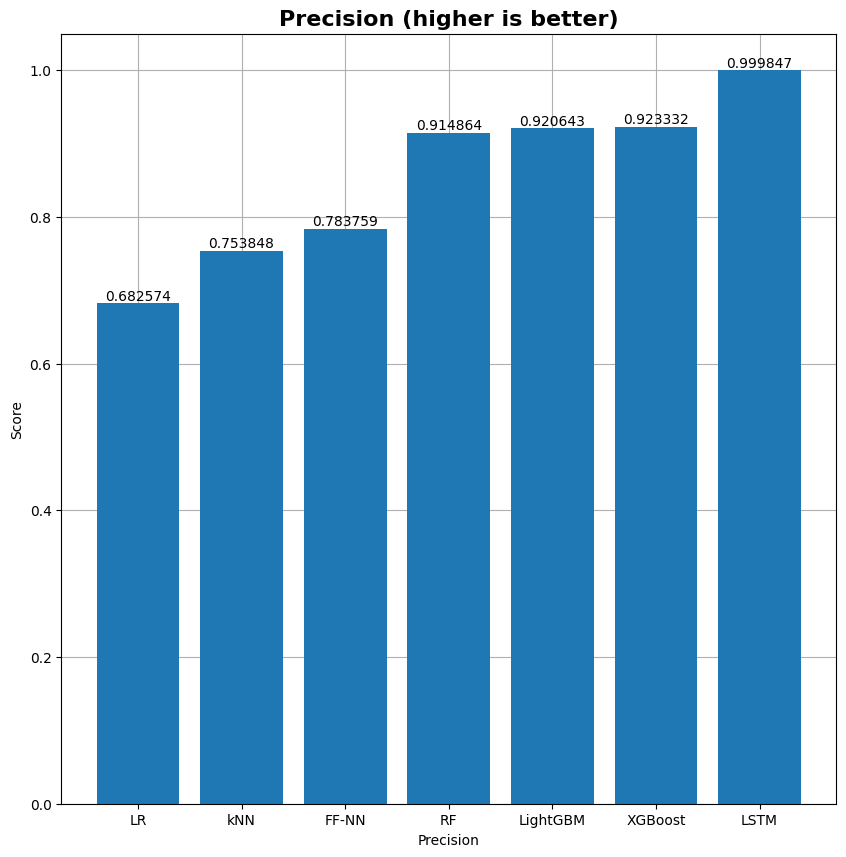

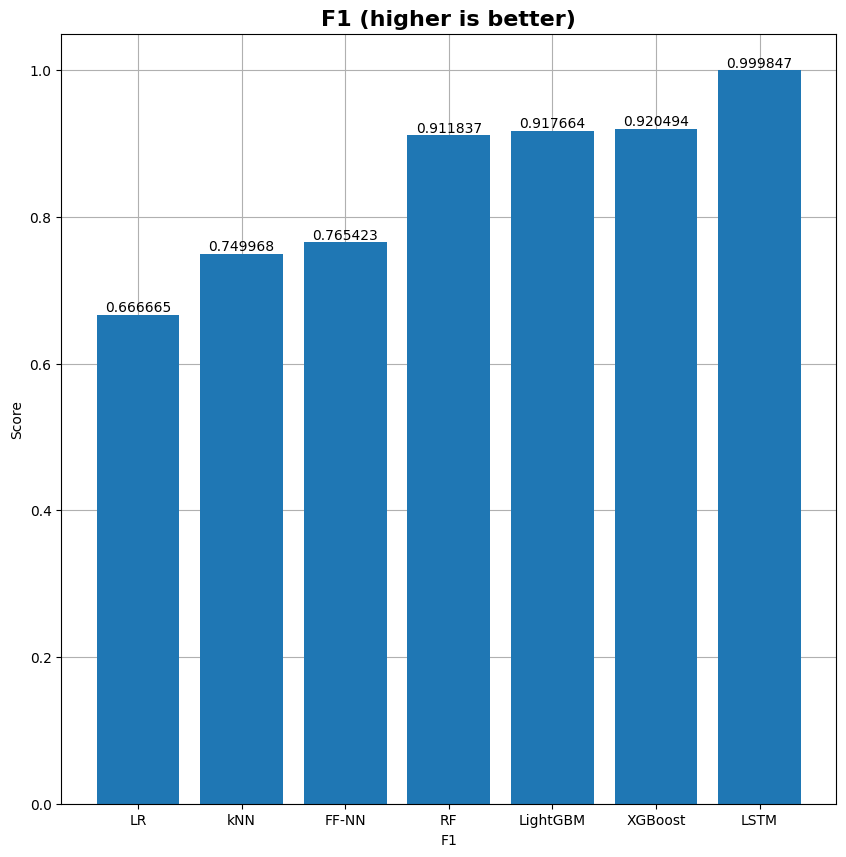

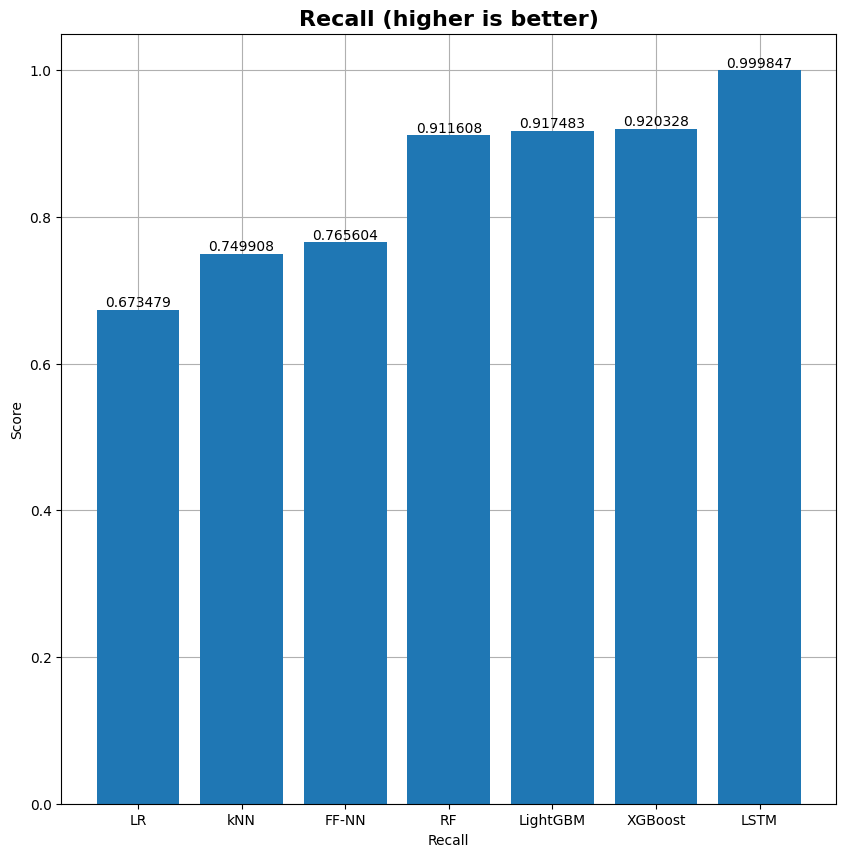

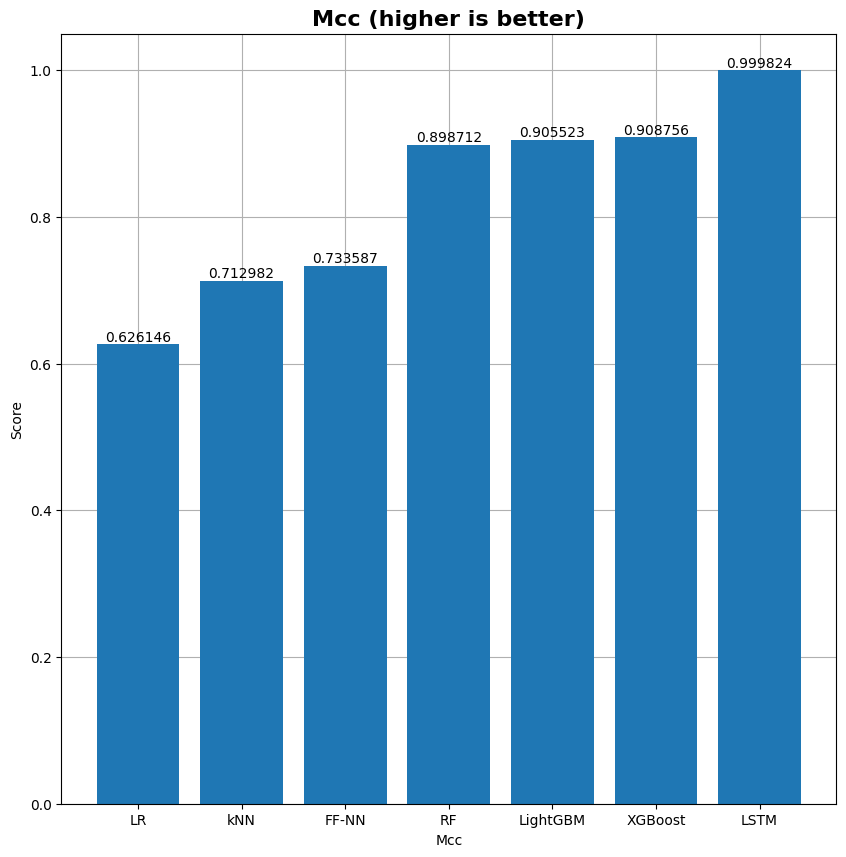

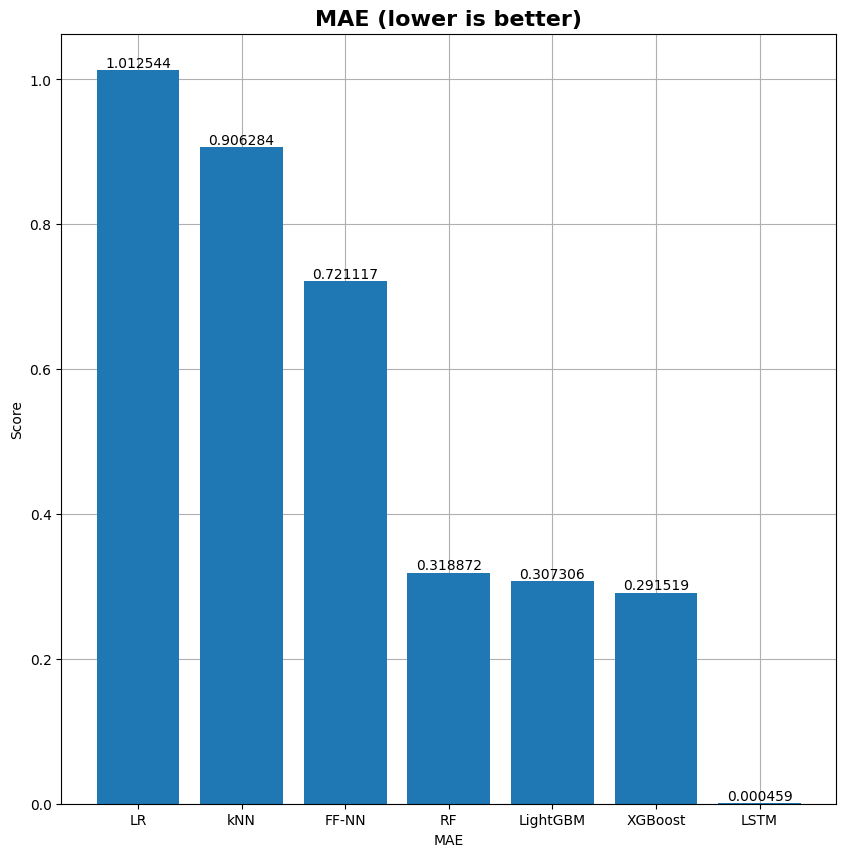

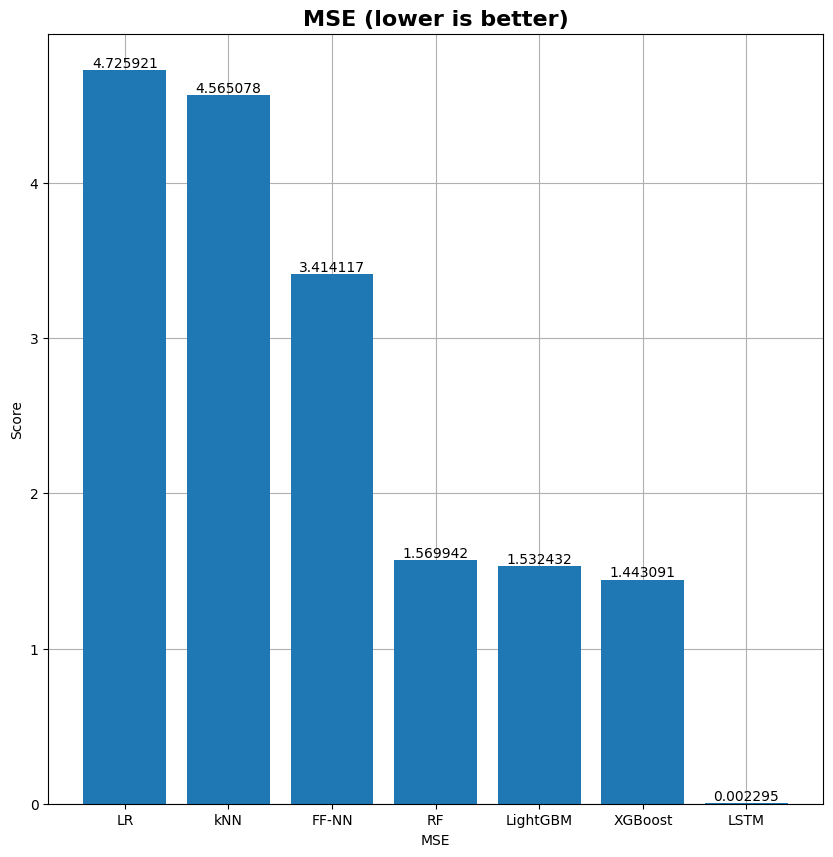

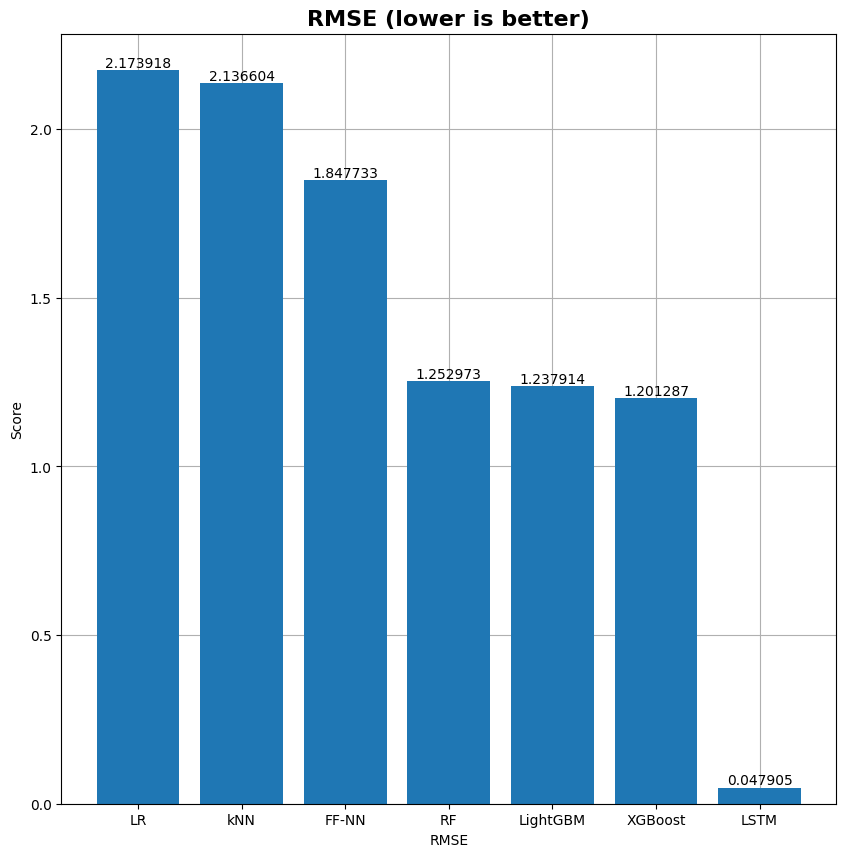

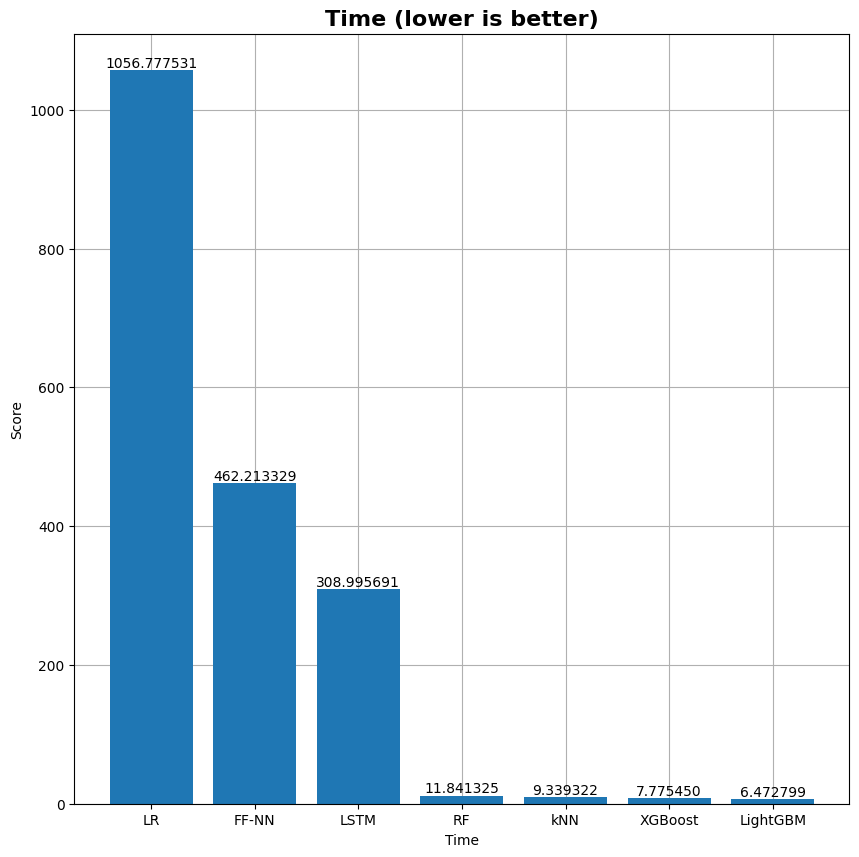

In [68]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])
for x in results_df:
    _dict = {}
    name = results_df[x].name
    for keys, values in zip(range(len(results_df[x].keys())), results_df[x]):
        _dict[results_df[x].keys()[keys]] = values
    result_plot(_dict, name, "multiclass", "")